# 0. Environment Setup

## Mount Google Drive

To access the GitHub project and associated files, you need to mount your Google Drive to Colab. This process allows you to read and write files directly from your Google Drive within the Colab environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your parameters

Please make sure to update the following parameters to your own:

- **Project ID**: The BigQuery project ID to query the MIMIC-III v1.4 raw data. (If you're not sure what your project ID is, check details in `notebooks/MIMIC_III_Data_Access_Instructions.ipynb`.)
- **BASE_PATH**: The path where the GitHub project will be cloned.

In [2]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/GitHub_Testing"

## Importing libraries.

In [3]:
%cd {BASE_PATH}/SepsisOnset_TraumaCohort

import os
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

# for dataset
# from scripts.all_icu_data import load_or_generate_nighttime_df
# for model
from tensorflow.keras.utils import to_categorical

# Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/SepsisOnset_TraumaCohort')

/content/drive/MyDrive/GitHub_Testing/SepsisOnset_TraumaCohort


In [4]:
MODEL_FOLDER = '/content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model'
DATA_FOLDER = project_path_obj.final_dataset_path

## Load Dataset

### All ICU Data

In [5]:
file_path = os.path.join(DATA_FOLDER, 'nighttime_allICU_18to6H_7F_filled_final.pkl')

if os.path.exists(file_path):
    print(f"Loading existing nighttime data from {file_path}")
    night_ti_df = pd.read_pickle(file_path)
else:
    print(f"File not found: {file_path}")

print(night_ti_df.shape)
# Drop Nan
is_any_nan = night_ti_df['Temporal Features'].apply(lambda x: np.isnan(x).any())
night_df_filled = night_ti_df[~is_any_nan]
night_df_filled

Loading existing nighttime data from /content/drive/MyDrive/GitHub_Testing/SepsisOnset_TraumaCohort/dataset/nighttime_allICU_18to6H_7F_filled_final.pkl
(283062, 7)


subject_id  hadm_id  icustay_id        Date  Night  \
0            58526   100001      275225  2117-09-11      1   
2            58526   100001      275225  2117-09-13      3   
4            54610   100003      209281  2150-04-17      1   
5            54610   100003      209281  2150-04-18      2   
6             9895   100006      291788  2108-04-06      1   
...            ...      ...         ...         ...    ...   
283057       27200   199998      293589  2119-02-20      3   
283058       40370   199999      211153  2136-04-06      3   
283059       40370   199999      211153  2136-04-07      4   
283060       40370   199999      211153  2136-04-08      5   
283061       40370   199999      211153  2136-04-09      6   

                                        Temporal Features  \
0       [[112.0, 170.0, 86.0, 106.0, 16.0, 36.61111111...   
2       [[96.0, 171.0, 94.0, 113.0, 18.0, 37.388888888...   
4       [[72.0, 85.0, 43.5, 54.0, 14.666666666666666, ...   
5       [[85.0, 128.0, 56.0, 74.0, 16.0, 36.3888888888...   
6       [[122.0, 124.0, 70.0, 88.0, 18.0, 36.111111111...   
...                                                   ...   
283057  [[85.0, 146.0, 57.5, 85.0, 19.0, 37.5999984741...   
283058  [[64.0, 134.0, 51.0, 73.0, 17.0, 36.5555555555...   
283059  [[67.0, 143.0, 52.0, 74.0, 28.0, 36.4444444444...   
283060  [[80.0, 167.0, 54.0, 84.0, 23.0, 36.5, 95.0], ...   
283061  [[90.0, 146.0, 53.0, 79.0, 24.0, 36.6666666666...   

                                                    isNan  
0       [[False, False, False, False, False, True, Fal...  
2       [[False, False, False, False, True, True, True...  
4       [[False, False, False, False, False, True, Fal...  
5       [[False, False, False, False, False, True, Fal...  
6       [[False, False, False, False, False, True, Fal...  
...                                                   ...  
283057  [[False, False, False, False, False, False, Fa...  
283058  [[False, False, False, False, False, True, Fal...  
283059  [[False, False, False, False, False, False, Fa...  
283060  [[False, False, False, False, False, True, Fal...  
283061  [[False, False, False, False, False, True, Fal...  

[212115 rows x 7 columns]

### Trauma Cohot
In this section, we will load the complete Post-Traumatic Sepsis dataset (without missing values), which is derived from the MIMIC-III v1.4 dataset. For a comprehensive explanation of the dataset construction and additional relevant information, please refer to the `notebooks/Early_Sepsis_Onset_Detection_Setup.ipynb` file.

The dataset table comprises the following columns:

- **Temporal Features**: Multivariate time-series input data with dimensions (# of timestamps, # of features).

Each row in the dataset corresponds to one nighttime instance, and includes patient identifiers (`subject_id`, `hadm_id`) and a timestamp ID (`Date`, `Night`).

In [6]:
file_path = os.path.join(DATA_FOLDER, 'PostTraumaticSepsis_dataset_wo_nan.pkl')

if os.path.exists(file_path):
    print(f"Loading existing nighttime data from {file_path}")
    truma_cohort_df = pd.read_pickle(file_path)
else:
    print(f"File not found: {file_path}")

truma_cohort_ids = truma_cohort_df.hadm_id.unique()
positive_samples = truma_cohort_df[truma_cohort_df.Label == 1]
print("# of truma", truma_cohort_ids.shape[0],
      f"# of positive sample {positive_samples.shape[0]} of sepsis pacient {positive_samples.hadm_id.nunique()}")
truma_cohort_df.head()

Loading existing nighttime data from /content/drive/MyDrive/GitHub_Testing/SepsisOnset_TraumaCohort/dataset/PostTraumaticSepsis_dataset_wo_nan.pkl
# of truma 1522 # of positive sample 440 of sepsis pacient 440


subject_id  hadm_id        Date Night  \
0       19984   100132  2179-03-06   002   
1       19984   100132  2179-03-07   003   
2       19984   100132  2179-03-08   004   
3       19984   100132  2179-03-09   005   
4       19984   100132  2179-03-10   006   

                                   Temporal Features  \
0  [[90.0, 142.0, 73.0, 99.0, 16.0, 37.5555547078...   
1  [[97.0, 129.0, 61.0, 86.0, 20.0, 36.2222205268...   
2  [[68.0, 87.0, 47.0, 60.33330154418945, 15.0, 3...   
3  [[96.0, 133.0, 71.0, 91.6667022705078, 22.0, 3...   
4  [[107.0, 188.0, 85.0, 119.33300018310548, 23.0...   

                                               isNan  Label onset_datetime  \
0  [[0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, ...      0            NaN   
1  [[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...      0            NaN   
2  [[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...      0            NaN   
3  [[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...      0            NaN   
4  [[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...      0            NaN   

   Fold  
0     3  
1     3  
2     3  
3     3  
4     3

In [7]:
truma_subject_ids = truma_cohort_df.subject_id.unique()

truma_records = night_df_filled[night_df_filled.subject_id.isin(truma_subject_ids)]
nontruma_records = night_df_filled[~night_df_filled.subject_id.isin(truma_subject_ids)]
print(truma_records.shape, nontruma_records.shape)

(19759, 7) (192356, 7)


## Sample

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nighttime_features(
    sample: np.array,
    feature_names: list[str],
    start_hour: int = 18,
    title: str = "Nighttime Features (6 pm → 6 am)"
) -> pd.DataFrame:
    """
    Build a DataFrame indexed from start_hour through next-day 6 am,
    then plot all features over that 13-hour window.

    Parameters
    ----------
    sample : array-like, shape (T=13, F)
        2D array of T hourly measurements.
    feature_names : list of str, length F
        Column names for each feature.
    start_hour : int, optional
        Hour to start labeling (default 18 for 6 pm).
    title : str, optional
        Plot title.

    Returns
    -------
    sample_df : pd.DataFrame
        DataFrame of the sample, indexed by hour labels.
    """
    T = sample.shape[0]
    # generate labels "18:00, 19:00, …, 23:00, 00:00, …, 06:00"
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # build DataFrame with custom index
    sample_df = pd.DataFrame(sample, columns=feature_names, index=hour_labels)
    # display(sample_df)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    for col in sample_df.columns:
        ax.plot(sample_df.index, sample_df[col], label=col)

    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1),   # (x, y) relative to axes

              )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return sample_df

(13, 7)


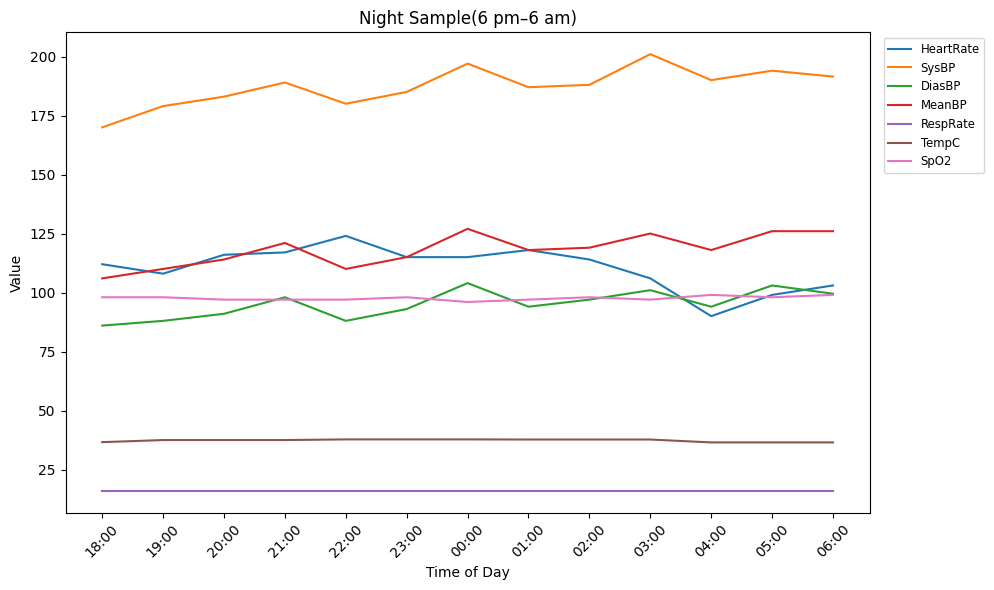

HeartRate  SysBP  DiasBP  MeanBP  RespRate      TempC  SpO2
18:00      112.0  170.0    86.0   106.0      16.0  36.611111  98.0
19:00      108.0  179.0    88.0   110.0      16.0  37.500000  98.0
20:00      116.0  183.0    91.0   114.0      16.0  37.500000  97.0
21:00      117.0  189.0    98.0   121.0      16.0  37.500000  97.0
22:00      124.0  180.0    88.0   110.0      16.0  37.777778  97.0
23:00      115.0  185.0    93.0   115.0      16.0  37.777778  98.0
00:00      115.0  197.0   104.0   127.0      16.0  37.777778  96.0
01:00      118.0  187.0    94.0   118.0      16.0  37.722222  97.0
02:00      114.0  188.0    97.0   119.0      16.0  37.722222  98.0
03:00      106.0  201.0   101.0   125.0      16.0  37.722222  97.0
04:00       90.0  190.0    94.0   118.0      16.0  36.500000  99.0
05:00       99.0  194.0   103.0   126.0      16.0  36.500000  98.0
06:00      103.0  191.5    99.5   126.0      16.0  36.500000  99.0

In [9]:
print(night_df_filled['Temporal Features'][0].shape) #T:13(6pm-6am), F:['HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2']

sample = night_df_filled['Temporal Features'][0]
feature_names = ['HeartRate', 'SysBP', 'DiasBP', 'MeanBP',
                 'RespRate', 'TempC', 'SpO2', #'Glucose', 'fio2'
                 ]
plot_nighttime_features(sample, feature_names=feature_names,
                        start_hour=18, title= "Night Sample(6 pm–6 am)")

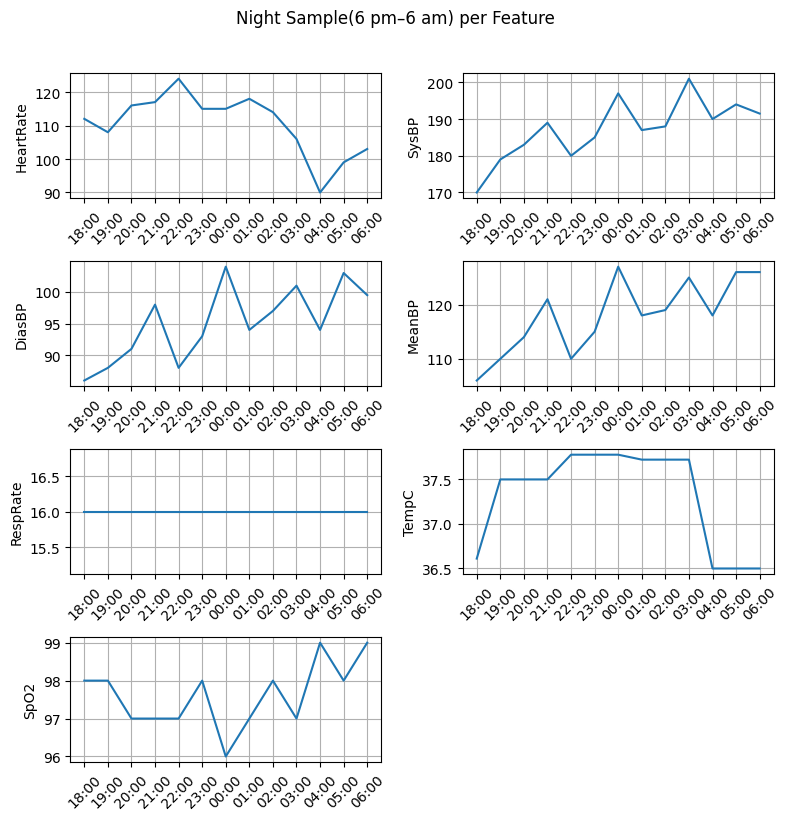

HeartRate  SysBP  DiasBP  MeanBP  RespRate      TempC  SpO2
18:00      112.0  170.0    86.0   106.0      16.0  36.611111  98.0
19:00      108.0  179.0    88.0   110.0      16.0  37.500000  98.0
20:00      116.0  183.0    91.0   114.0      16.0  37.500000  97.0
21:00      117.0  189.0    98.0   121.0      16.0  37.500000  97.0
22:00      124.0  180.0    88.0   110.0      16.0  37.777778  97.0
23:00      115.0  185.0    93.0   115.0      16.0  37.777778  98.0
00:00      115.0  197.0   104.0   127.0      16.0  37.777778  96.0
01:00      118.0  187.0    94.0   118.0      16.0  37.722222  97.0
02:00      114.0  188.0    97.0   119.0      16.0  37.722222  98.0
03:00      106.0  201.0   101.0   125.0      16.0  37.722222  97.0
04:00       90.0  190.0    94.0   118.0      16.0  36.500000  99.0
05:00       99.0  194.0   103.0   126.0      16.0  36.500000  98.0
06:00      103.0  191.5    99.5   126.0      16.0  36.500000  99.0

In [10]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_nighttime_features_subplots(
    sample: np.array,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Nighttime Features"
) -> pd.DataFrame:
    """
    Plot each feature in its own subplot over the 13-hour window,
    arranged in a grid with `ncols` columns.
    Each subplot shows its own x-axis labels.

    Returns the DataFrame for further inspection.
    """
    T, F = sample.shape
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]
    sample_df = pd.DataFrame(sample, columns=feature_names, index=hour_labels)

    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, col in enumerate(feature_names):
        ax = axes_flat[idx]
        ax.plot(range(T), sample_df[col], label=col)
        ax.set_ylabel(col)
        ax.grid(True)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)

    # 关闭多余的子图
    for ax in axes_flat[F:]:
        ax.axis('off')

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return sample_df


plot_nighttime_features_subplots(sample, feature_names=feature_names,
                        start_hour=18, title_prefix= "Night Sample(6 pm–6 am)")

In [11]:
# corrspondng features list: 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2', 'Glucose', 'fio2'
start_hour, T = 18,13
pd.DataFrame(night_df_filled.isNan[0], columns=['HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2',
                                                # 'Glucose', 'fio2'
                                                ],
             index=[f"{(start_hour + i) % 24:02d}:00" for i in range(T)])
# False: means not nan, or have raw data
# True: is nan, data is filled

HeartRate  SysBP  DiasBP  MeanBP  RespRate  TempC   SpO2
18:00      False  False   False   False     False   True  False
19:00      False  False   False   False      True  False   True
20:00      False  False   False   False      True   True  False
21:00      False  False   False   False      True   True   True
22:00      False  False   False   False      True  False  False
23:00      False  False   False   False      True   True  False
00:00      False  False   False   False      True   True  False
01:00      False  False   False   False      True  False  False
02:00      False  False   False   False      True   True  False
03:00      False  False   False   False      True   True  False
04:00      False  False   False   False      True  False  False
05:00      False  False   False   False      True   True  False
06:00      False  False   False    True      True   True  False

# Model

## Model Definition

### Autoencoder

In [12]:
keras.layers.GRU

keras.src.layers.rnn.gru.GRU

In [13]:
from keras import layers, models, Input
from keras.regularizers import l2

def Encoder_model(input_shape, name="encoder", drop_r=0.2):
    input_layer = Input(shape=input_shape)
    x = input_layer

    # LSTM Feature Extraction
    x = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001),
                                        reset_after=True
                                        ))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001),
                                        reset_after=True
                                        ))(x)
    x = layers.BatchNormalization()(x)

    # Feed Forward Part
    # FCL
    # x = layers.Dense(units=512, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(units=32, activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    # CNN
    # Feed Forward Part
    x = layers.Conv1D(filters=128, kernel_size=3, strides=1,
                      activation="relu", kernel_regularizer=l2(0.01),
                      # dilation_rate=1
                      )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, strides=2,
                      # dilation_rate=1s
                      )(x)
    x = layers.BatchNormalization()(x)

    # Output Feature Representation Vector
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    # x = layers.GlobalMaxPooling1D()(x)

    return models.Model(input_layer, x, name=name)

# def Decoder_model(T=9, F=6, feature_vector_shape=32, drop_r=0.2):
#     latent_inputs = Input(shape=feature_vector_shape[1:])
#     x = layers.RepeatVector(n=T)(latent_inputs)
#     x = layers.LSTM(units=256, return_sequences=True, kernel_regularizer=l2(0.01))(x)
#     x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(rate=drop_r)(x)
#     x = layers.Bidirectional(layers.LSTM(units=1024, return_sequences=True, kernel_regularizer=l2(0.01)))(x)
#     x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(rate=drop_r)(x)
#     dec_output = layers.TimeDistributed(layers.Dense(units=F, kernel_regularizer=l2(0.01)))(x)
#     return models.Model(latent_inputs, dec_output, name="decoder")


def multimodal_AutoEncoder(input_shape_li, drop_r=0.2):
    # Create input layers for each encoder
    raw_inputs = layers.Input(shape=input_shape_li[0])
    delta_inputs = layers.Input(shape=input_shape_li[1])
    inputs = [raw_inputs, delta_inputs]

    # Init Encoders
    raw_encoder = Encoder_model(input_shape_li[0], name="night_encoder")
    delta_encoder = Encoder_model(input_shape_li[1], name="delta_encoder")
    encoders = [raw_encoder, delta_encoder]

    # Pass inputs through respective encoders
    embeddings = [raw_encoder(raw_inputs),
                  delta_encoder(delta_inputs)]
    # Combine the embeddings (using Concatenate)
    combined_emb = layers.Concatenate()(embeddings)
    # # Combine the embeddings (using Add)
    # combined_emb = layers.Add()(embeddings)

    # Decoder
    # feature_vector_shape=encoder.output_shape
    # latent_inputs = Input(shape=feature_vector_shape[1:])
    T, F = input_shape_li[0]
    x = layers.RepeatVector(n=T)(combined_emb)
    # x = layers.LSTM(units=1, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=drop_r)(x)
    x = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=drop_r)(x)
    decoder_output = layers.TimeDistributed(layers.Dense(units=F, kernel_regularizer=l2(0.01)))(x)

    # Autoencoder
    autoencoder = models.Model(inputs, decoder_output, name="autoencoder")
    return encoders, autoencoder

# input_shape_li = [(13, 7), (13,7)] # T,F
# encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)

In [14]:
night_df_filled['Temporal Features'][0].shape

(13, 7)

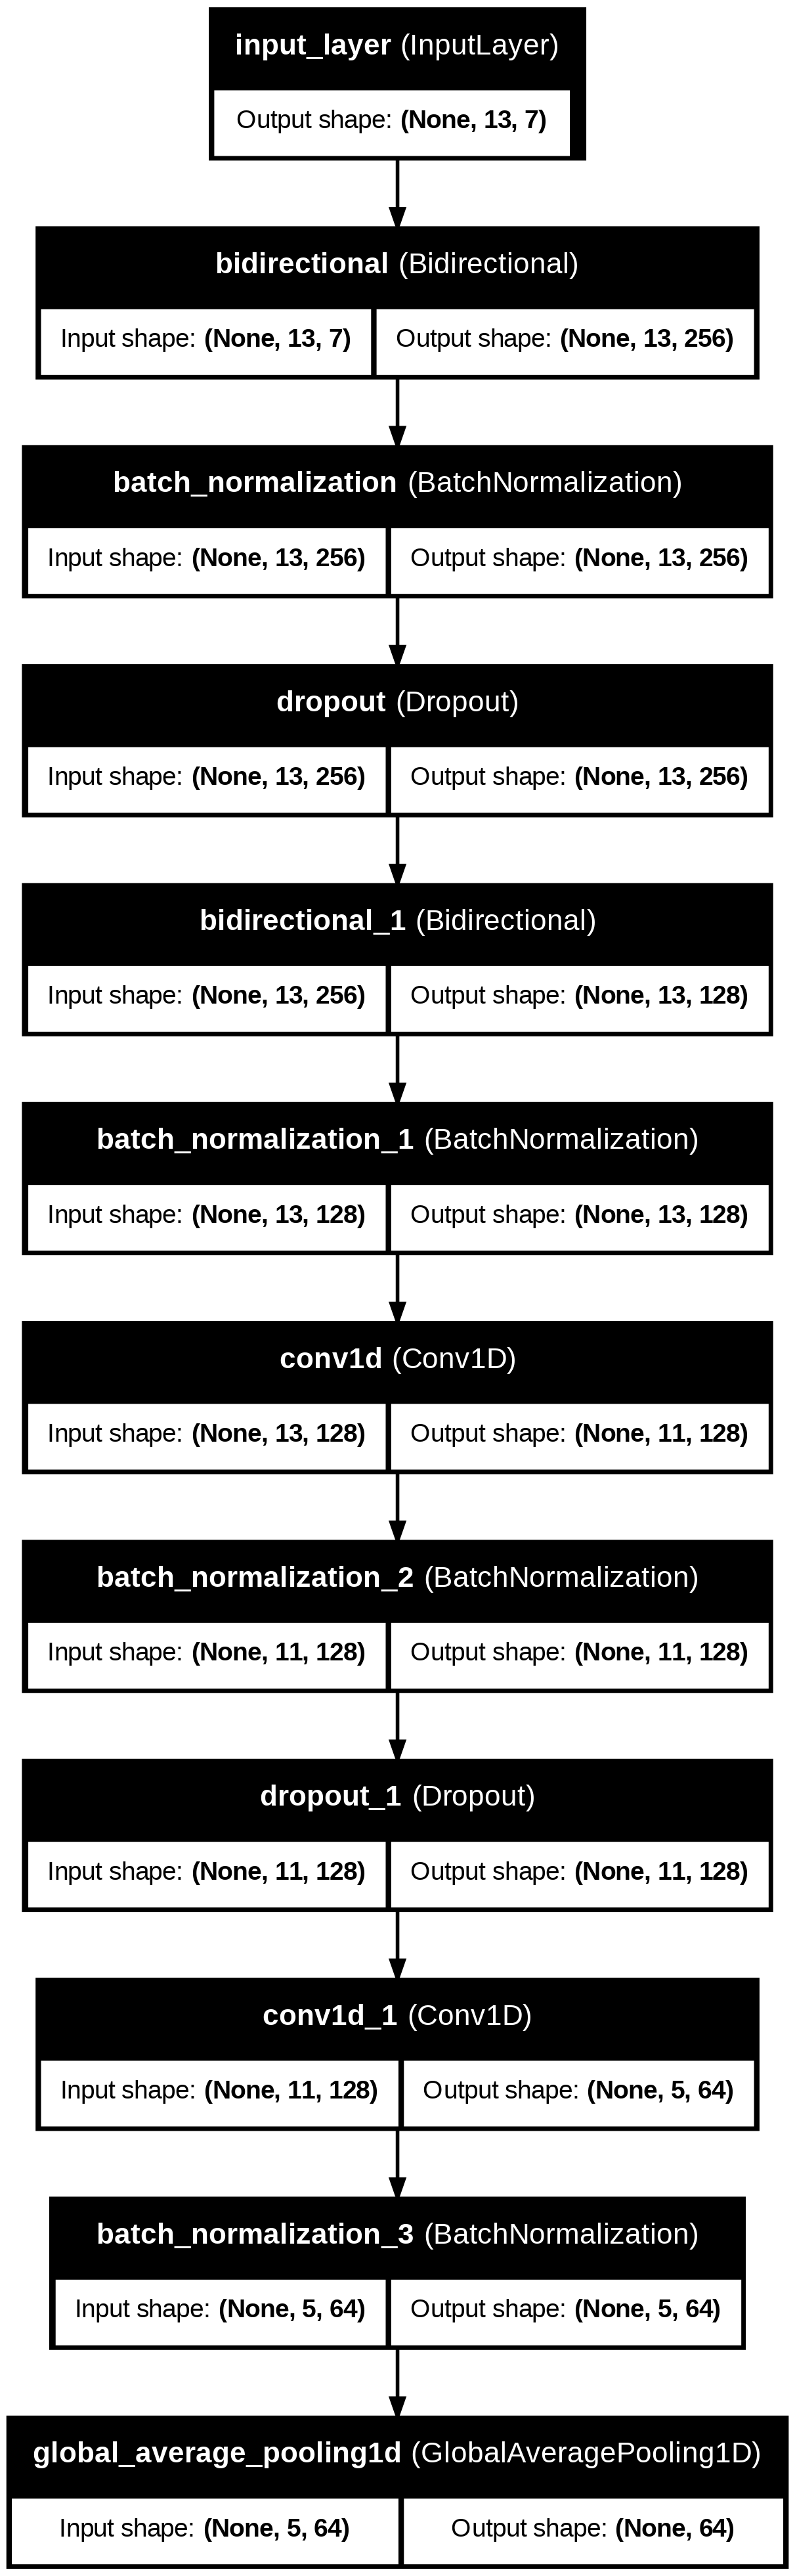

In [15]:
input_shape_li = [(13, 7), (13,7)]
# encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
raw_encoder = Encoder_model(input_shape_li[0], name="night_encoder")
keras.utils.plot_model(raw_encoder, show_shapes=True, show_layer_names=True)

Model: "night_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 13, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 13, 256)        │       105,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 13, 128)        │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,088 (1.16 MB)

 Trainable params: 303,936 (1.16 MB)

 Non-trainable params: 1,152 (4.50 KB)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 13, 128)   │          0 │ concatenate[0][0] │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 13, 128)   │     74,496 │ repeat_vector[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 128)   │        512 │ bidirectional_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 13, 256)   │    198,144 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 256)   │      1,024 │ bidirectional_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 13, 7)     │      1,799 │ batch_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 886,151 (3.38 MB)

 Trainable params: 883,079 (3.37 MB)

 Non-trainable params: 3,072 (12.00 KB)

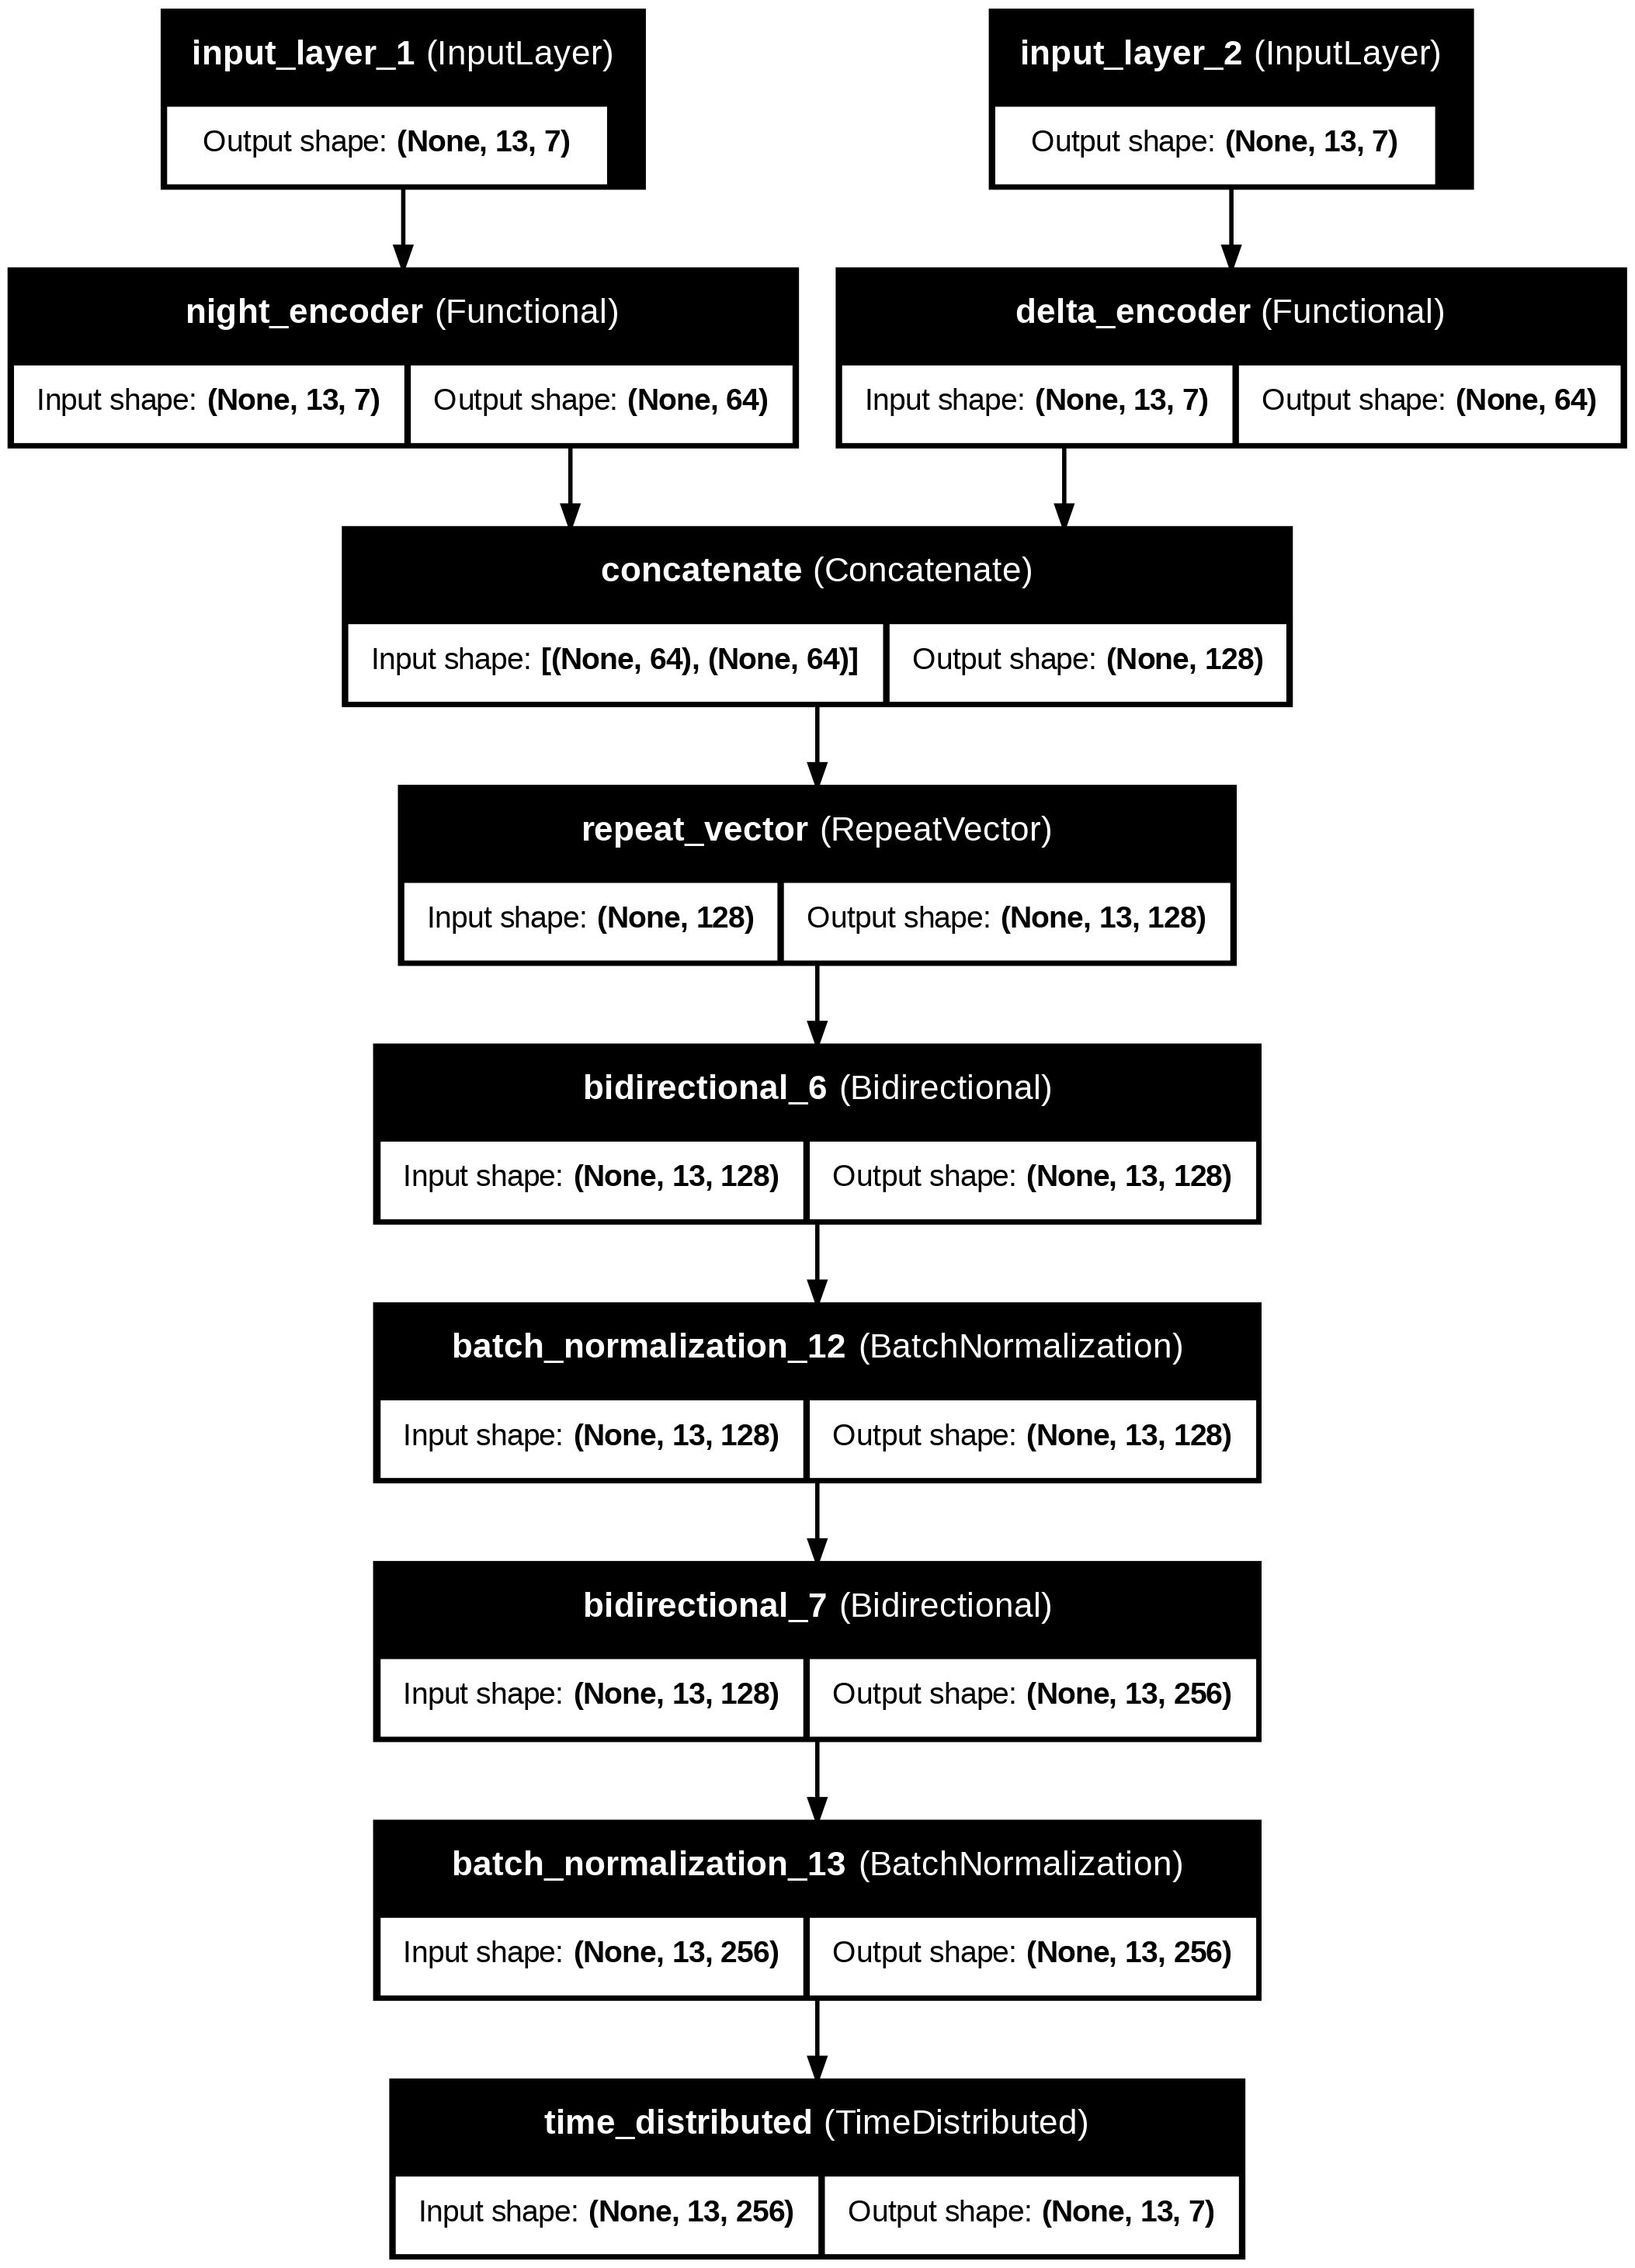

In [16]:
# Instantiate the models
input_shape_li = [(13, 7), (13,7)]
encoders, autoencoder = multimodal_AutoEncoder(input_shape_li)

# # Print summary of the autoencoder model
encoders[0].summary()
# encoders[1].summary()
autoencoder.summary()

keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True)

### Classification

Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_6[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None


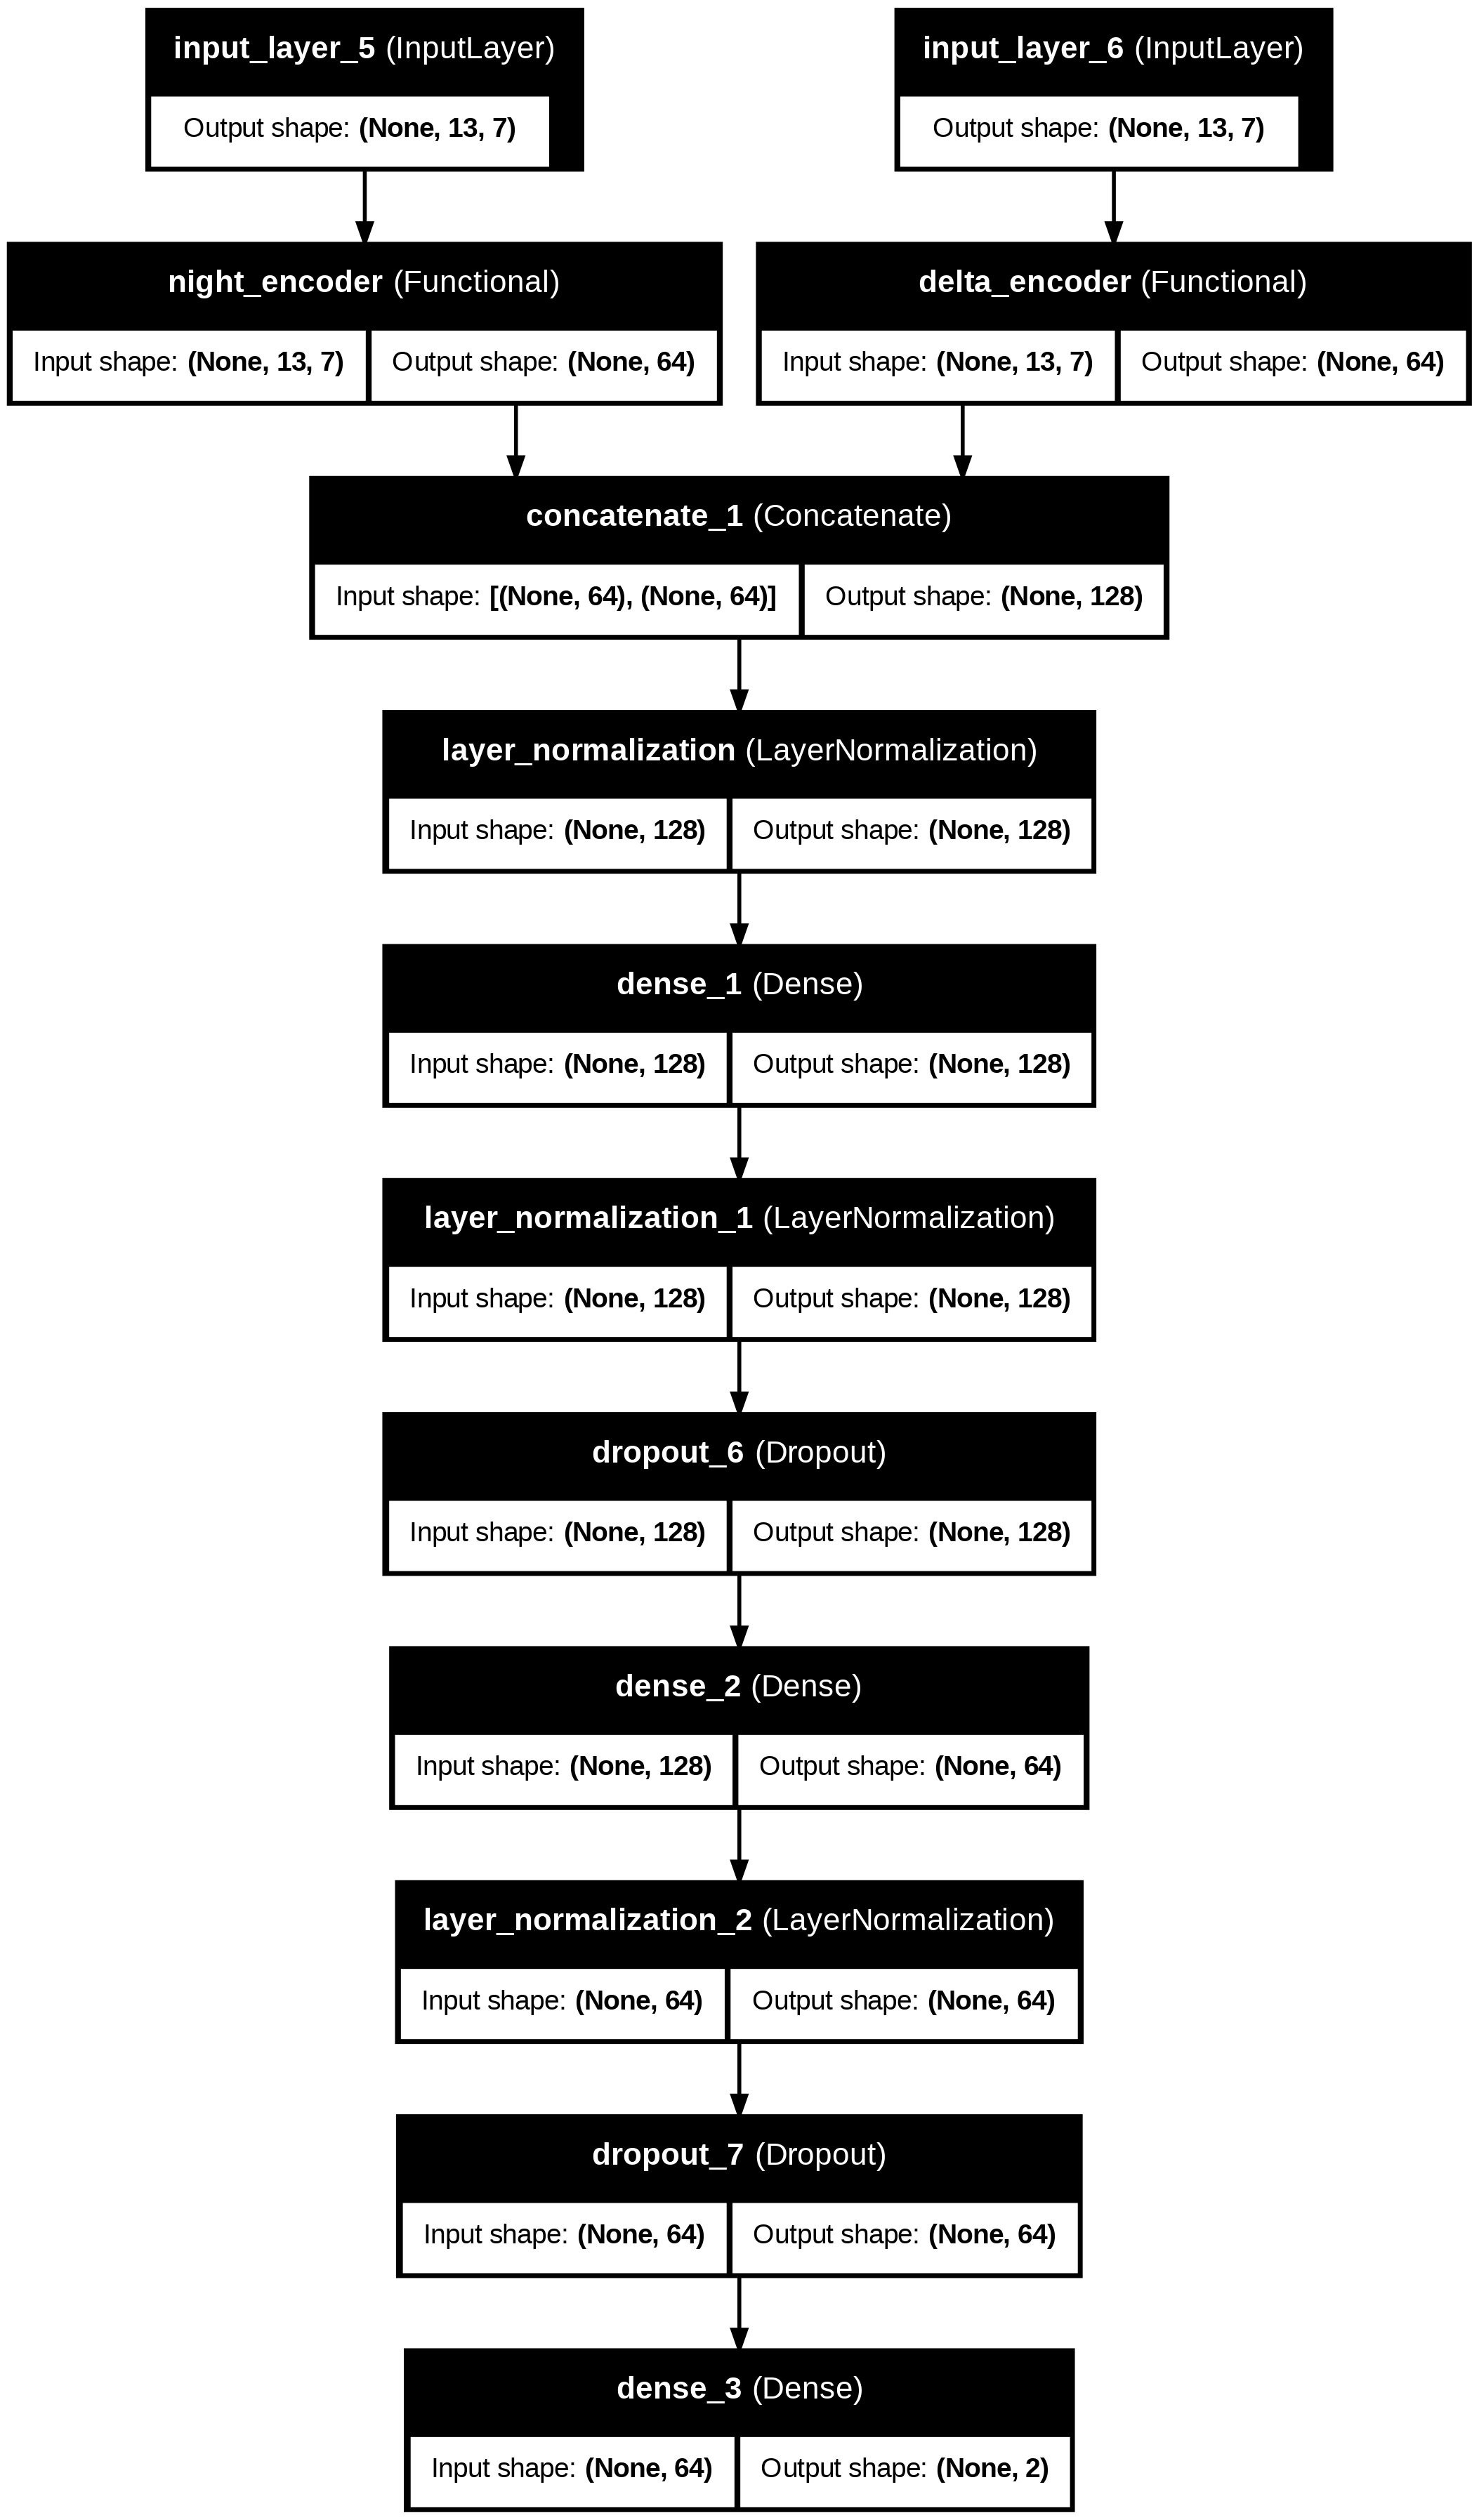

In [17]:
def classification_2encoder(input_shape_li, encoders,
                            freeze_encoders = False,
                            mlp_units=[128, 64],
                            mlp_dropout_rate=0.5, regularizers_l2=0.001):
    """
    Builds a classification model using a pre-trained encoder followed by fully connected layers.

    Args:
        input_shape_li (tuple): Shape of the input data (excluding batch size).
        encoder (Model): Pre-trained encoder model to extract features.
        mlp_units (list): List of integers defining the units in the MLP layers.
        mlp_dropout_rate (float): Dropout rate for the MLP layers.
        regularizers_l2 (float): L2 regularization factor for the Dense layers.

    Returns:
        Model: A Keras Model instance for classification.
    """
    # Create input layers for each encoder
    raw_inputs = layers.Input(shape=input_shape_li[0])
    delta_inputs = layers.Input(shape=input_shape_li[1])
    inputs = [raw_inputs, delta_inputs]

    # Init Encoders
    raw_encoder, delta_encoder = encoders
    if freeze_encoders:
        raw_encoder.trainable = False
        delta_encoder.trainable = False

    # Pass inputs through respective encoders
    embeddings = [raw_encoder(raw_inputs),
                  delta_encoder(delta_inputs)]
    # # Combine the embeddings (using Concatenate)
    combined_emb = layers.Concatenate()(embeddings)
    # # Combine the embeddings (using Add)
    # combined_emb = layers.Add()(embeddings)
    x = layers.LayerNormalization()(combined_emb)

    # Fully connected output layer
    for units in mlp_units:
        x = layers.Dense(units, activation="relu", kernel_regularizer=l2(regularizers_l2))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(mlp_dropout_rate)(x)
    outputs = layers.Dense(2, activation="softmax")(x)

    model = models.Model(inputs=inputs,
                         outputs=outputs,
                         name='dual_encoder_classifier')
    return model

input_shape_li = ((13, 7), (13, 7))
# encoders, _ = load_models(os.path.join(MODEL_FOLDER, f'MAE_nontruma_Jul9'), load_autoencoder=False)
classification_model = classification_2encoder(input_shape_li, encoders, freeze_encoders=True)
print(classification_model.summary())
keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

## Custom Fit and Loss Functions

In [18]:
# def masked_mae(y_true, y_pred, mask, alpha=1.0):
#     """
#     Weighted MAE for Masked-AE.
#     alpha = mask_weight_para in [0, 1]:
#         1.0 → loss from masked positions only
#         0.5 → half masked, half visible
#         0.0 → all positions equally
#     """
#     # element-wise L1 error
#     err = tf.abs(y_true - y_pred)

#     # visible = 1, masked = 0  ▸ convert to float32
#     mask = tf.cast(mask, tf.float32)

#     # build weights: w = (1-alpha)·visible + alpha·masked
#     weights = (1.0 - alpha) * mask + alpha * (1.0 - mask)

#     # masked mean
#     loss = tf.reduce_sum(err * weights) / tf.reduce_sum(weights)
#     return loss


In [19]:
# class MaskedReconstructionFit(tf.keras.Model):
#     def __init__(self, model, alpha=1.0):
#         super(MaskedReconstructionFit, self).__init__()
#         self.model = model
#         self.alpha = alpha         # mask_weight_para
#         # self.loss_fn = weight_mae
#         # self.test_loss_fn = tf.keras.losses.MeanAbsoluteError()
#         self.metric = tf.keras.metrics.MeanAbsoluteError()

#     def compile(self, optimizer, metrics=None, **kwargs):
#         super().compile(optimizer=optimizer, metrics=metrics, **kwargs)

#     def train_step(self, data):
#         (x, x_delta), mask = data  # data should be in the form (x, delta, mask)
#         mask = tf.cast(mask, tf.float32)
#         masked_x = x * mask  # Apply the mask to the input
#         # masked_x_delta = x_delta * mask
#         # tf.print("Masked input (masked_x):", masked_x, summarize=-1)  # summarize=-1 prints the full tensor

#         with tf.GradientTape() as tape:
#             x_hat = self.model([masked_x, x_delta], training=True)
#             loss  = masked_mae(x, x_hat, mask, self.alpha)

#         # Compute gradients and update weights
#         gradients = tape.gradient(loss, self.model.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

#         # Update the reconstruction loss metric
#         self.metric.update_state(x, x_hat)
#         # Return the reconstruction loss as the only metric
#         return {"loss": loss, "global_MAE": self.metric.result()}



#     def test_step(self, data):
#         (x, x_delta), mask = data  # data should be in the form (x, delta, mask)
#         mask = tf.cast(mask, tf.float32)
#         x_visible = x * mask              # zero-out masked positions

#         x_hat = self.model([x_visible, x_delta], training=False)
#         loss  = masked_mae(x, x_hat, mask, self.alpha)

#         # Update the reconstruction loss metric
#         self.metric.update_state(x, x_hat)
#         # ---- build log dict (TOP-LEVEL keys!) ----
#         return {"loss": loss, "global_MAE":self.metric.result()}


## Evaluation and Learning Curve Plotting Function

In [20]:
def plot_learning_curves(training_history, log_history=None, name='', metric_name_li=[], init_index=0):
    """
    Plots the learning curves for training and validation loss/accuracy.

    Parameters:
    - training_history: The history object returned from model.fit.

    Returns:
    - None (Displays the plots).
    """
    if log_history is not None:
        history_data = log_history
    else:
        history_data = training_history.history

    # Loop through each metric in the history
    if len(metric_name_li) == 0:
      for metric_name in history_data.keys():
          if 'val' not in metric_name:
              metric_name_li.append(metric_name)

    for metric_name in metric_name_li:
            epochs = range(init_index+1, len(history_data[metric_name]) + 1)
            # print(len(epochs), len(history_data[metric_name][init_index:]))

            # Create a new figure for each metric
            metric_fig = plt.figure(figsize=(4, 3))
            plt.plot(epochs, history_data[metric_name][init_index:], label=f'Training {metric_name}')
            plt.plot(epochs, history_data[f'val_{metric_name}'][init_index:], label=f'Validation {metric_name}')

            # Formatting the plot
            plt.title(f'{metric_name.capitalize()}-{name}')
            plt.xlabel('Epochs')
            plt.ylabel(metric_name.capitalize())
            plt.legend()
            plt.grid(True)

            # Display the plot
            # metric_fig.tight_layout()
            metric_fig.show()
    return

# plot_learning_curves(history, init_index=5)

In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
def evaluate_model(y_true, y_pred_probs, metrics):
    """
    Evaluates the model's performance using various metrics and updates the metrics dictionary.

    Parameters:
    - y_true: True labels (numpy array or list).
    - y_pred_probs: Predicted probabilities (numpy array).
    - metrics: Dictionary to update with evaluation metrics.

    Returns:
    - None
    """
    # Convert probabilities to binary predictions
    y_pred = np.argmax(y_pred_probs, axis=1)
    # Keep only probability for positive class
    y_pred_pos = y_pred_probs[:, 1]

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['tn'].append(tn)
    metrics['fp'].append(fp)
    metrics['fn'].append(fn)
    metrics['tp'].append(tp)

    # Calculate precision and recall
    specificity, sensitivity = recall_score(y_true, y_pred, average=None) #recall for both
    metrics['sensitivity'].append(sensitivity)
    metrics['specificity'].append(specificity)
    precision = precision_score(y_true, y_pred) #only for positive class
    metrics['precision'].append(precision)
    f1 = f1_score(y_true, y_pred)
    metrics['f1_score'].append(f1)

    # PR curve
    precision_li, recall_li, thresholds_pr = precision_recall_curve(y_true, y_pred_pos)
    pr_auc = auc(recall_li, precision_li)
    metrics['PR_auc'].append(pr_auc)

    # ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_pos)
    roc_auc = auc(fpr, tpr)
    metrics['ROC_auc'].append(roc_auc)

    # Store metrics in a DataFrame
    metrics_data = {
        "Metric": [
            "True Negatives", "False Positives", "False Negatives", "True Positives",
            "Sensitivity", "Specificity", "Precision", "F1 Score", "PR AUC", "ROC AUC"
        ],
        "Value": [tn, fp, fn, tp, sensitivity, specificity, precision, f1, pr_auc, roc_auc]
    }
    display(pd.DataFrame(metrics_data))

    return

## Save Model

In [22]:
from tensorflow.keras.models import save_model

def save_models(encoders, autoencoder, save_dir):
    """
    Saves encoders (list of two models) and autoencoder model to the given directory.

    Parameters:
    - encoders (list): A list containing two Keras models (encoder models).
    - autoencoder (Model): The main autoencoder model.
    - save_dir (str): Directory path where models will be saved.

    Returns:
    - None (saves models to disk).
    """

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save encoder models
    save_model(encoders[0], os.path.join(save_dir, "encoder_1.h5"))
    save_model(encoders[1], os.path.join(save_dir, "encoder_2.h5"))

    # Save autoencoder model
    save_model(autoencoder, os.path.join(save_dir, "autoencoder.h5"))

    print(f"Models saved in: {save_dir}")


from tensorflow.keras.models import load_model
def load_models(load_dir, load_autoencoder=True):
    """
    Loads two encoder models and optionally an autoencoder model from the specified directory.

    Parameters:
    - load_dir (str): Directory path where models are saved.
    - load_autoencoder (bool): Whether to load the autoencoder model (default is True).

    Returns:
    - encoders (list): A list containing two loaded encoder models.
    - autoencoder (Model or None): The loaded autoencoder model if `load_autoencoder=True`, else None.
    """

    # Ensure the directory exists
    if not os.path.exists(load_dir):
        raise FileNotFoundError(f"Directory {load_dir} does not exist. Please check the path.")

    # Load encoder models
    encoder_1 = load_model(os.path.join(load_dir, "encoder_1.h5"))
    encoder_2 = load_model(os.path.join(load_dir, "encoder_2.h5"))

    encoders = [encoder_1, encoder_2]

    # Load autoencoder model if specified
    autoencoder = None
    if load_autoencoder:
        autoencoder = load_model(os.path.join(load_dir, "autoencoder.h5"))
        print(f"Autoencoder loaded successfully from: {load_dir}")

    print(f"Encoders loaded successfully from: {load_dir}")

    return encoders, autoencoder


# Data Preprocess

## Sampling with mask strategy

In [23]:
from sklearn.utils import shuffle

def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked
    Returns:
        (L,) boolean numpy array intended to mask ('drop') with 0s a sequence of length L
    """
    # np.random.seed(seed)
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask

def noise_mask(X, masking_ratio, lm=3, mode='separate', distribution='geometric', exclude_feats=None):
    """
    Creates a random boolean mask of the same shape as X, with 0s at places where a feature should be masked.
    Args:
        X: (seq_length, feat_dim) numpy array of features corresponding to a single sample
        masking_ratio: proportion of seq_length to be masked. At each time step, will also be the proportion of
            feat_dim that will be masked on average
        lm: average length of masking subsequences (streaks of 0s). Used only when `distribution` is 'geometric'.
        mode: whether each variable should be masked separately ('separate'), or all variables at a certain positions
            should be masked concurrently ('concurrent')
        distribution: whether each mask sequence element is sampled independently at random, or whether
            sampling follows a markov chain (and thus is stateful), resulting in geometric distributions of
            masked squences of a desired mean length `lm`
        exclude_feats: iterable of indices corresponding to features to be excluded from masking (i.e. to remain all 1s)
    Returns:
        boolean numpy array with the same shape as X, with 0s at places where a feature should be masked
    """
    # np.random.seed(seed)
    if exclude_feats is not None:
        exclude_feats = set(exclude_feats)

    if distribution == 'geometric':  # stateful (Markov chain)
        if mode == 'separate':  # each variable (feature) is independent
            mask = np.ones(X.shape, dtype=bool)
            for m in range(X.shape[1]):  # feature dimension
                if exclude_feats is None or m not in exclude_feats:
                    mask[:, m] = geom_noise_mask_single(X.shape[0], lm, masking_ratio)  # time dimension
        else:  # replicate across feature dimension (mask all variables at the same positions concurrently)
            mask = np.tile(np.expand_dims(geom_noise_mask_single(X.shape[0], lm, masking_ratio), 1), X.shape[1])
    else:  # each position is independent Bernoulli with p = 1 - masking_ratio
        if mode == 'separate':
            mask = np.random.choice(np.array([True, False]), size=X.shape, replace=True,
                                    p=(1 - masking_ratio, masking_ratio))
        else:
            mask = np.tile(np.random.choice(np.array([True, False]), size=(X.shape[0], 1), replace=True,
                                            p=(1 - masking_ratio, masking_ratio)), X.shape[1])

    return mask

def Gen_Mask(X, r=0.15, lm=2):
  '''
  Gen mask Matrix for a given training sample
  '''
  M = noise_mask(X, r, lm, mode='separate', distribution='geometric', exclude_feats=None)
  M = np.where(M, 1, 0)
  return M

def Gen_Masked_data(X, M):
  '''
  Gen mask input Matrix as target for lossfunction for training process
  '''
  Y = np.multiply(X, np.subtract(1, M))
  return Y

def Gen_Unmask_Data(X, M):
  '''
  Gen un-mask Matrix for training process
  '''
  X = np.multiply(X,M)
  return X

## Normalization

In [24]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_features_array(train_X: np.ndarray,
                             val_X:   np.ndarray,
                             test_X:  np.ndarray,
                             eps: float = 0.05):
    """
    Min–max-scales each feature to the interval [eps, 1].

    Parameters
    ----------
    train_X, val_X, test_X : np.ndarray
        Arrays with shape (N, T, F).
    eps : float, optional
        Lower bound of the scaled range (default 0.05).

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        Normalised (train, val, test) arrays.
    """
    # reshape to 2-D (samples × features)
    N, T, F = train_X.shape
    train_flat = train_X.reshape(-1, F)

    # fit scaler on *training* data only
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    train_flat_norm = scaler.fit_transform(train_flat)

    # apply the same scaler to val
    val_flat_norm  = scaler.transform(val_X.reshape(-1, F))

    # reshape back to (N, T, F)
    train_norm = train_flat_norm.reshape(N, T, F)
    val_norm   = val_flat_norm.reshape(val_X.shape[0], T, F)

    if test_X is not None:
      test_flat_norm = scaler.transform(test_X.reshape(-1, F))
      test_norm  = test_flat_norm.reshape(test_X.shape[0], T, F)
    else:
      test_norm = None

    return train_norm, val_norm, test_norm


def denormalize_with_trained_scaler(
    X_norm:    np.ndarray,  # (N, T, F) — data in [eps, 1]
    train_X:   np.ndarray,  # (N_train, T, F) — raw training set
    eps: float = 0.05
) -> np.ndarray:
    """
    1. Reshape raw training data to (samples, features).
    2. Fit MinMaxScaler(feature_range=(eps, 1.0)) on it.
    3. Apply inverse_transform to X_norm and reshape back.

    Returns
    -------
    X_raw  : de-normalised array, same shape as X_norm.
    scaler : the fitted MinMaxScaler (handy for later use).
    """
    # reshape training data
    N_train, T, F = train_X.shape
    train_flat = train_X.reshape(-1, F)

    # fit scaler
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    scaler.fit(train_flat)

    # inverse-transform the normalised array
    X_raw = scaler.inverse_transform(X_norm.reshape(-1, F)).reshape(X_norm.shape)
    return X_raw

# Preprocess 2 Night data

In [25]:
def generate_2night_data(df):
    df = df.reset_index()
    # Extract previous day data
    previous_day_df = df.shift(1).iloc[1:]
    previous_day_df['Night'] = previous_day_df['Night'].astype(int)

    df = df.iloc[1:]
    df['PreviousNight'] = previous_day_df['Night']

    # Generate 2 night
    TwoNight_df = pd.DataFrame()
    TwoNight_df['subject_id'] = df.subject_id
    TwoNight_df['hadm_id'] = df.hadm_id
    TwoNight_df['Night'] = df.apply(lambda row: f"{row.PreviousNight}--{row.Night}", axis=1)
    TwoNight_df['PreviousNight'] = previous_day_df['Temporal Features']
    TwoNight_df['CurrentNight'] = df['Temporal Features']
    TwoNight_df['Delta'] = TwoNight_df.apply(
        lambda row: row.CurrentNight - row.PreviousNight
        if isinstance(row["PreviousNight"], np.ndarray) else np.nan
        , axis=1
        )
    if 'Label' in df.columns:
        TwoNight_df['Label'] = df.Label
        TwoNight_df['Fold'] = df.Fold

    TwoNight_df = TwoNight_df.dropna()

    # TwoNight_df['InputFeatures'] = TwoNight_df.apply(
    #     lambda row: np.concatenate((row["CurrentNight"], row['Delta']), axis=1)
    #     if isinstance(row["Delta"], np.ndarray) else np.nan
    #     , axis=1
    # )
    # TwoNight_df['InputFeatures'] = TwoNight_df['CurrentNight']

    # # Drop duplicate data
    # TwoNight_df.drop(['PreviousNight', #'CurrentNight', #'Delta'
    #                   ], axis=1, inplace=True)

    return TwoNight_df

In [26]:
from imblearn.over_sampling import RandomOverSampler

def random_oversample_dual_input(
    X1: np.ndarray,
    X2: np.ndarray,
    y:  np.ndarray,
    random_state: int | None = 42,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Randomly oversample a dual-input (multi-modal) dataset so each class reaches
    the size of the majority class.

    Parameters
    ----------
    X1, X2 : np.ndarray
        Two input tensors with identical first-dimension length, shapes
        (N, T, F). They are flattened & concatenated internally.
    y : np.ndarray
        Label vector of shape (N,).
    random_state : int | None, optional
        Seed for reproducibility (default 42).

    Returns
    -------
    X1_os, X2_os, y_os : np.ndarray
        Oversampled copies of the two inputs and labels, shapes
        (N_new, T, F) and (N_new,).
    """
    # --- Sanity check ------------------------------------------------------
    assert X1.shape == X2.shape, "X1 and X2 must share (N, T, F) shape"
    N, T, F = X1.shape

    # --- 1. Flatten & concatenate ------------------------------------------
    X_concat = np.hstack([X1.reshape(N, -1), X2.reshape(N, -1)])  # (N, 2·T·F)

    # --- 2. Random oversampling -------------------------------------------
    ros = RandomOverSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(X_concat, y)

    # --- 3. Split & reshape back ------------------------------------------
    split = T * F
    X1_os = X_res[:, :split].reshape(-1, T, F)
    X2_os = X_res[:, split:].reshape(-1, T, F)
    return X1_os, X2_os, y_res

## training

In [27]:
dataset_df = truma_cohort_df[['subject_id', 'hadm_id', 'Night', 'Temporal Features','Label', 'Fold']].sort_values(['hadm_id', 'Night'])
dataset_df['Night']= dataset_df.Night.astype(int)
NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)

# Drop non Continuous Day
isContinuousDay = NightAndDelta_dataset["Night"].apply(
    lambda x: (lambda a, b: b - a == 1)(*map(int, x.split('--')))
)

NightAndDelta_dataset_Continuous = NightAndDelta_dataset[isContinuousDay]

NightAndDelta_dataset_Continuous.head()

/tmp/ipython-input-547857484.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)


subject_id  hadm_id Night  \
hadm_id                                
100011  1       87977   100011  2--3   
        2       87977   100011  3--4   
        3       87977   100011  4--5   
        4       87977   100011  5--6   
100035  1       48539   100035  4--5   

                                               PreviousNight  \
hadm_id                                                        
100011  1  [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...   
        2  [[109.33333333333333, 158.33333333333334, 82.6...   
        3  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
        4  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100035  1  [[84.0, 112.0, 58.0, 73.0, 22.0, 37.6, 98.0], ...   

                                                CurrentNight  \
hadm_id                                                        
100011  1  [[109.33333333333333, 158.33333333333334, 82.6...   
        2  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
        3  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
        4  [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...   
100035  1  [[92.0, 141.0, 80.0, 97.0, 14.0, 38.2, 96.0], ...   

                                                       Delta  Label  Fold  
hadm_id                                                                    
100011  1  [[21.33333333333333, -8.666666666666657, 0.666...      0     4  
        2  [[-12.333333333333329, -15.333333333333343, -1...      0     4  
        3  [[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...      0     4  
        4  [[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...      1     4  
100035  1  [[8.0, 29.0, 22.0, 24.0, -8.0, 0.6000000000000...      1     2

In [28]:
# 1.  Ensure the second level never exceeds 999  (you said it is 0 – 295)
assert NightAndDelta_dataset_Continuous.index.get_level_values(1).max() < 1_000

# 2.  Collapse the two levels:
NightAndDelta_dataset_Continuous.index = (
    NightAndDelta_dataset_Continuous.index.get_level_values(0) * 1_000   # reserve three digits
    + NightAndDelta_dataset_Continuous.index.get_level_values(1)
).astype("int64")          # → Int64Index like 100001001

# 3.  (optional) give the new single‐level index a name
NightAndDelta_dataset_Continuous.index.name = "instence_id"
NightAndDelta_dataset_Continuous

subject_id  hadm_id   Night  \
instence_id                                
100011001         87977   100011    2--3   
100011002         87977   100011    3--4   
100011003         87977   100011    4--5   
100011004         87977   100011    5--6   
100035001         48539   100035    4--5   
...                 ...      ...     ...   
199976008         26198   199976   9--10   
199976009         26198   199976  10--11   
199976010         26198   199976  11--12   
199976011         26198   199976  12--13   
199976012         26198   199976  13--14   

                                                 PreviousNight  \
instence_id                                                      
100011001    [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...   
100011002    [[109.33333333333333, 158.33333333333334, 82.6...   
100011003    [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
100011004    [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100035001    [[84.0, 112.0, 58.0, 73.0, 22.0, 37.6, 98.0], ...   
...                                                        ...   
199976008    [[83.5, 168.75, 60.25, 95.5, 16.5, 38.66666581...   
199976009    [[82.0, 204.5, 64.0, 111.1666488647461, 24.0, ...   
199976010    [[89.0, 156.0, 55.5, 87.0, 18.0, 37.3888905843...   
199976011    [[73.0, 155.5, 55.0, 84.6666488647461, 19.0, 3...   
199976012    [[74.0, 154.0, 55.0, 86.6666488647461, 21.0, 3...   

                                                  CurrentNight  \
instence_id                                                      
100011001    [[109.33333333333333, 158.33333333333334, 82.6...   
100011002    [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
100011003    [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100011004    [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...   
100035001    [[92.0, 141.0, 80.0, 97.0, 14.0, 38.2, 96.0], ...   
...                                                        ...   
199976008    [[82.0, 204.5, 64.0, 111.1666488647461, 24.0, ...   
199976009    [[89.0, 156.0, 55.5, 87.0, 18.0, 37.3888905843...   
199976010    [[73.0, 155.5, 55.0, 84.6666488647461, 19.0, 3...   
199976011    [[74.0, 154.0, 55.0, 86.6666488647461, 21.0, 3...   
199976012    [[95.0, 178.0, 58.0, 94.0, 28.0, 37.4444452921...   

                                                         Delta  Label  Fold  
instence_id                                                                  
100011001    [[21.33333333333333, -8.666666666666657, 0.666...      0     4  
100011002    [[-12.333333333333329, -15.333333333333343, -1...      0     4  
100011003    [[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...      0     4  
100011004    [[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...      1     4  
100035001    [[8.0, 29.0, 22.0, 24.0, -8.0, 0.6000000000000...      1     2  
...                                                        ...    ...   ...  
199976008    [[-1.5, 35.75, 3.75, 15.666648864746094, 7.5, ...      0     0  
199976009    [[7.0, -48.5, -8.5, -24.166648864746094, -6.0,...      0     0  
199976010    [[-16.0, -0.5, -0.5, -2.3333511352539062, 1.0,...      0     0  
199976011    [[1.0, -1.5, 0.0, 2.0, 2.0, -0.222223069932724...      0     0  
199976012    [[21.0, 24.0, 3.0, 7.333351135253906, 7.0, -0....      0     0  

[7141 rows x 8 columns]

## Sample

In [29]:
df_100011 = dataset_df[dataset_df['hadm_id']==100011]
display(df_100011)
NightAndDelta_dataset_Continuous[NightAndDelta_dataset_Continuous['hadm_id'] == 100011]

subject_id  hadm_id  Night  \
6821       87977   100011      2   
6822       87977   100011      3   
6823       87977   100011      4   
6824       87977   100011      5   
6825       87977   100011      6   

                                      Temporal Features  Label  Fold  
6821  [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...      0     4  
6822  [[109.33333333333333, 158.33333333333334, 82.6...      0     4  
6823  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...      0     4  
6824  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...      0     4  
6825  [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...      1     4

subject_id  hadm_id Night  \
instence_id                              
100011001         87977   100011  2--3   
100011002         87977   100011  3--4   
100011003         87977   100011  4--5   
100011004         87977   100011  5--6   

                                                 PreviousNight  \
instence_id                                                      
100011001    [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...   
100011002    [[109.33333333333333, 158.33333333333334, 82.6...   
100011003    [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
100011004    [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   

                                                  CurrentNight  \
instence_id                                                      
100011001    [[109.33333333333333, 158.33333333333334, 82.6...   
100011002    [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
100011003    [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100011004    [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...   

                                                         Delta  Label  Fold  
instence_id                                                                  
100011001    [[21.33333333333333, -8.666666666666657, 0.666...      0     4  
100011002    [[-12.333333333333329, -15.333333333333343, -1...      0     4  
100011003    [[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...      0     4  
100011004    [[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...      1     4

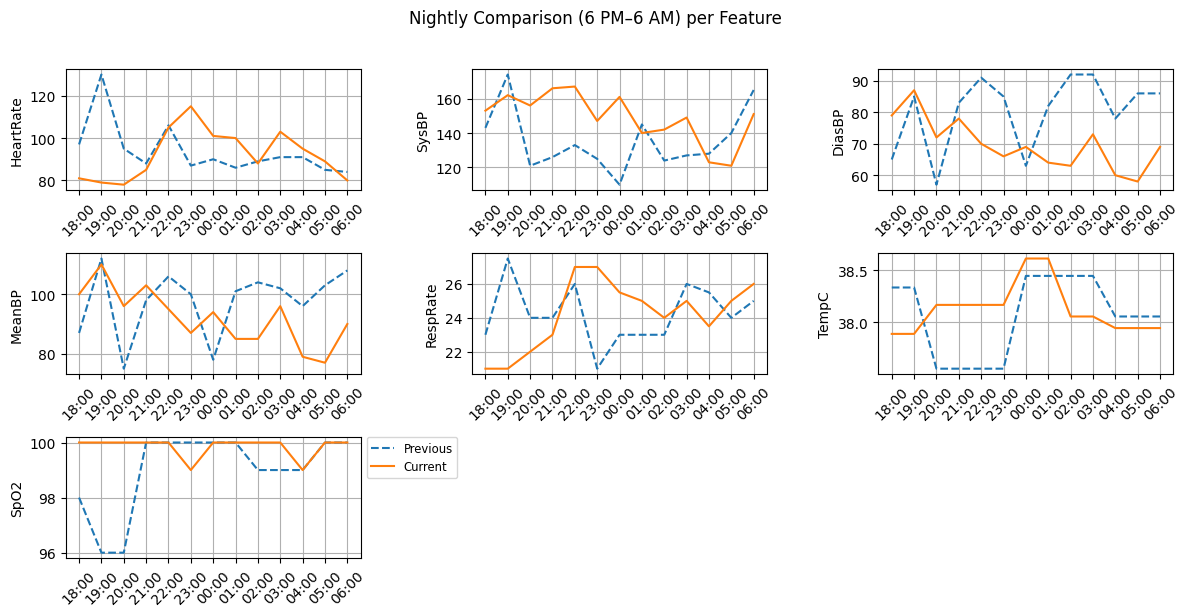

In [30]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_two_nights_features_subplots(
    sample_prev: np.ndarray,
    sample_curr: np.ndarray,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Nighttime Features"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    在每个子图中对比前一夜和当夜同一特征的时序：
    - sample_prev、sample_curr：形状均为 (T, F) 的数组
    - feature_names：长度为 F 的特征名列表
    - start_hour：开始小时（如 18 表示 18:00）
    - ncols：子图每行列数
    - title_prefix：整体标题前缀

    返回两个 DataFrame (df_prev, df_curr)，方便后续检查。
    """
    # 校验输入
    T, F = sample_curr.shape
    assert sample_prev.shape == sample_curr.shape, "两个样本的形状必须相同 (T, F)"

    # 构造时间标签
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # 构造 DataFrame
    df_prev = pd.DataFrame(sample_prev, columns=feature_names, index=hour_labels)
    df_curr = pd.DataFrame(sample_curr, columns=feature_names, index=hour_labels)

    # 子图布局
    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, feature in enumerate(feature_names):
        ax = axes_flat[idx]
        # 绘制前一夜（虚线）和当夜（实线）
        ax.plot(range(T), df_prev[feature], label="Previous", linestyle="--")
        ax.plot(range(T), df_curr[feature], label="Current",   linestyle="-")
        ax.set_ylabel(feature)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)
        ax.grid(True)

    ax.legend(
        ["Previous", "Current"],
        loc="upper left",
        fontsize="small",
        # bbox_to_anchor 的第一个参数 >1 表示在轴外右侧
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )

    for ax in axes_flat[F:]:
        ax.axis('off')

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return df_prev, df_curr

# usage sample
idx = 2
sample_prev = NightAndDelta_dataset_Continuous.iloc[idx]['PreviousNight']
sample_curr = NightAndDelta_dataset_Continuous.iloc[idx]['CurrentNight']
df_prev, df_curr = plot_two_nights_features_subplots(
    sample_prev, sample_curr, feature_names,
    start_hour=18, ncols=3,
    title_prefix="Nightly Comparison (6 PM–6 AM)"
)


# STAGE2: Transfer Learning

*  Transfer Learning Training model (freeze encoders), only trian on classification head



In [31]:
model_name = 'GRUMAE_nontruma_Jul28_1500'

# Load pretrained encoders
encoders, _ = load_models(os.path.join(MODEL_FOLDER, model_name), load_autoencoder=False)
# Save a snapshot of the initial weights
raw_init_w   = encoders[0].get_weights()
delta_init_w = encoders[1].get_weights()

Encoders loaded successfully from: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/GRUMAE_nontruma_Jul28_1500


In [32]:
BATCH_SIZE   = 64
# EPOCHS       = 50

# # lr scheduler
# MIN_LR = 1e-5
# FACTOR = 0.8
# PATIENCE = 2

# Mask

In [33]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def fit_minmax_scaler(train_X: np.ndarray, eps: float = 0.05) -> MinMaxScaler:
    """
    Fit a MinMaxScaler to training data only.

    Parameters
    ----------
    train_X : np.ndarray
        Training data of shape (N, T, F).
    eps : float
        Lower bound of the scaled range. Default is 0.05.

    Returns
    -------
    scaler : MinMaxScaler
        Fitted scaler object.
    """
    _, _, F = train_X.shape
    train_flat = train_X.reshape(-1, F)
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    scaler.fit(train_flat)
    return scaler

def normalize_with_scaler(X: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    """
    Normalize input data using a fitted MinMaxScaler.

    Supports both (N, T, F) and (T, F) shaped arrays.

    Parameters
    ----------
    X : np.ndarray
        Input array with shape (N, T, F) or (T, F).
    scaler : MinMaxScaler
        Previously fitted scaler.

    Returns
    -------
    X_norm : np.ndarray
        Normalized array with same shape as input.
    """
    original_shape = X.shape
    if X.ndim == 3:
        N, T, F = X.shape
        flat = X.reshape(-1, F)
        flat_norm = scaler.transform(flat)
        return flat_norm.reshape(N, T, F)
    elif X.ndim == 2:
        T, F = X.shape
        flat_norm = scaler.transform(X)
        return flat_norm.reshape(T, F)
    else:
        raise ValueError("Input must have shape (N, T, F) or (T, F).")


def denormalize_with_scaler(X_norm: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    """
    Inverse-transform normalized data using a fitted MinMaxScaler.

    Supports both (N, T, F) and (T, F) shaped arrays.

    Parameters
    ----------
    X_norm : np.ndarray
        Normalized array of shape (N, T, F) or (T, F).
    scaler : MinMaxScaler
        Previously fitted scaler.

    Returns
    -------
    X_raw : np.ndarray
        De-normalized array of same shape as input.
    """
    original_shape = X_norm.shape
    if X_norm.ndim == 3:
        N, T, F = X_norm.shape
        flat_norm = X_norm.reshape(-1, F)
        flat_raw = scaler.inverse_transform(flat_norm)
        return flat_raw.reshape(N, T, F)
    elif X_norm.ndim == 2:
        T, F = X_norm.shape
        flat_raw = scaler.inverse_transform(X_norm)
        return flat_raw.reshape(T, F)
    else:
        raise ValueError("Input must have shape (N, T, F) or (T, F).")


In [34]:
import pandas as pd
from sklearn.utils import resample

def oversample_binary_df(df: pd.DataFrame, target_column: str, random_state: int = 66) -> pd.DataFrame:
    """
    Perform oversampling on the minority class to balance a binary classification dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    target_column : str
        Name of the binary label column.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Balanced dataframe with equal number of samples from each class.
    """
    # Split majority and minority
    df_majority = df[df[target_column] == 0]
    df_minority = df[df[target_column] == 1]

    # Resample
    df_minority_oversampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=random_state
    )

    # Combine and shuffle
    df_balanced = pd.concat([df_majority, df_minority_oversampled])
    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return df_balanced


## Mask 0.5

### Mask 0.5 (Dropout 0; Reg_L2=1e-2)

In [35]:
Dropout = 0
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 30
PATIENCE_ES  = 30

MASK_RATE = 0.5


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/30
170/170 - 15s - 90ms/step - loss: 2.4954 - roc_auc: 0.5694 - sensitivity: 0.5524 - specificity: 0.5533 - val_loss: 2.1141 - val_roc_auc: 0.5418 - val_sensitivity: 0.4114 - val_specificity: 0.6492
Epoch 2/30
170/170 - 4s - 25ms/step - loss: 1.7931 - roc_auc: 0.6177 - sensitivity: 0.5979 - specificity: 0.5714 - val_loss: 1.5853 - val_roc_auc: 0.5597 - val_sensitivity: 0.3205 - val_specificity: 0.7265
Epoch 3/30
170/170 - 4s - 25ms/step - loss: 1.3757 - roc_auc: 0.6316 - sensitivity: 0.6152 - specificity: 0.5788 - val_loss: 1.2636 - val_roc_auc: 0.5648 - val_sensitivity: 0.5985 - val_specificity: 0.5121
Epoch 4/30
170/170 - 4s - 25ms/step - loss: 1.1251 - roc_auc: 0.6439 - sensitivity: 0.6415 - specificity: 0.5675 - val_loss: 1.0791 - val_roc_auc: 0.5746 - val_sensitivity: 0.3833 - val_specificity: 0.7114
Epoch 5/30
170/170 - 5s - 27ms/step - loss: 0.9745 - roc_auc: 0.6567 - sensitivity: 0.6463 - specificity: 0.5759 - val_loss: 0.9920 - val_roc_auc: 0.5734 - val_sensitivit

Metric       Value
0   True Negatives  708.000000
1  False Positives  612.000000
2  False Negatives   33.000000
3   True Positives   49.000000
4      Sensitivity    0.597561
5      Specificity    0.536364
6        Precision    0.074130
7         F1 Score    0.131898
8           PR AUC    0.095241
9          ROC AUC    0.600416

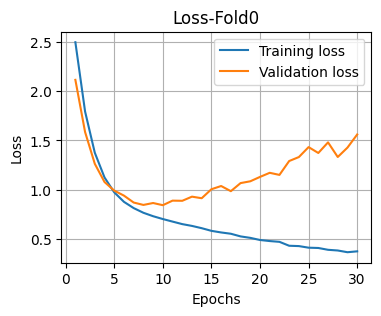

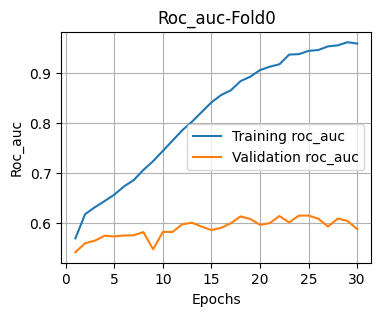

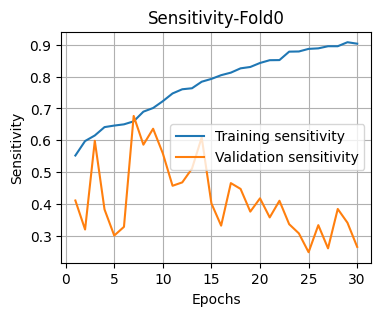

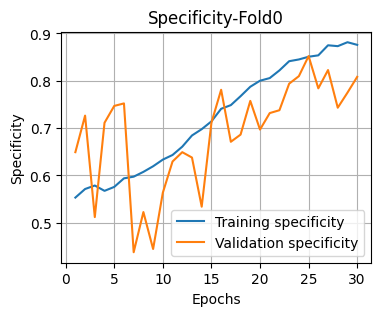

In [36]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [37]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.5 Dropout 0 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  708  612  33  49     0.597561     0.536364    0.07413  0.131898  0.095241   

    ROC_auc  
0  0.600416


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     708.0  612.0  33.0  49.0     0.597561     0.536364    0.07413  0.131898   
mean  708.0  612.0  33.0  49.0     0.597600     0.536400    0.07410  0.131900   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.095241  0.600416  
mean  0.095200  0.600400  
std        NaN       NaN

In [38]:
classification_model.get_weights()[0][0][0], raw_init_w[0][0][0]

(np.float32(-2.884097), np.float32(-2.884097))

### Mask 0.5 (Dropout 0; Reg_L2=1e-4)

In [39]:
Dropout = 0
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 30
PATIENCE_ES  = 30

MASK_RATE = 0.5


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/30
170/170 - 15s - 86ms/step - loss: 0.7399 - roc_auc: 0.5729 - sensitivity: 0.5413 - specificity: 0.5650 - val_loss: 0.7313 - val_roc_auc: 0.5644 - val_sensitivity: 0.3061 - val_specificity: 0.7765
Epoch 2/30
170/170 - 4s - 25ms/step - loss: 0.6925 - roc_auc: 0.6202 - sensitivity: 0.5825 - specificity: 0.5890 - val_loss: 0.7189 - val_roc_auc: 0.5636 - val_sensitivity: 0.4606 - val_specificity: 0.6364
Epoch 3/30
170/170 - 4s - 24ms/step - loss: 0.6830 - roc_auc: 0.6411 - sensitivity: 0.6219 - specificity: 0.5844 - val_loss: 0.7288 - val_roc_auc: 0.5519 - val_sensitivity: 0.4856 - val_specificity: 0.5856
Epoch 4/30
170/170 - 4s - 26ms/step - loss: 0.6745 - roc_auc: 0.6562 - sensitivity: 0.6372 - specificity: 0.5895 - val_loss: 0.7273 - val_roc_auc: 0.5631 - val_sensitivity: 0.5121 - val_specificity: 0.5909
Epoch 5/30
170/170 - 4s - 24ms/step - loss: 0.6615 - roc_auc: 0.6784 - sensitivity: 0.6516 - specificity: 0.6028 - val_loss: 0.7365 - val_roc_auc: 0.5471 - val_sensitivit

Metric       Value
0   True Negatives  950.000000
1  False Positives  370.000000
2  False Negatives   53.000000
3   True Positives   29.000000
4      Sensitivity    0.353659
5      Specificity    0.719697
6        Precision    0.072682
7         F1 Score    0.120582
8           PR AUC    0.068429
9          ROC AUC    0.552393

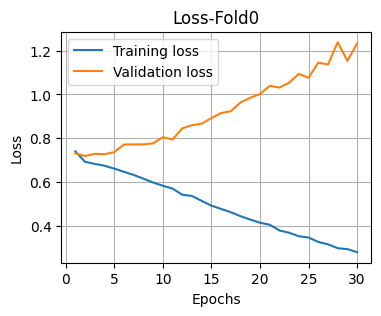

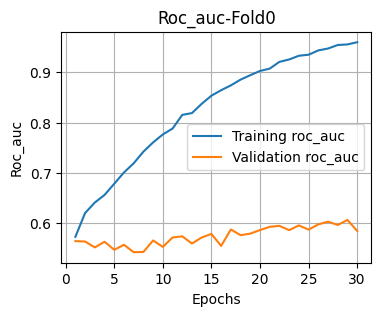

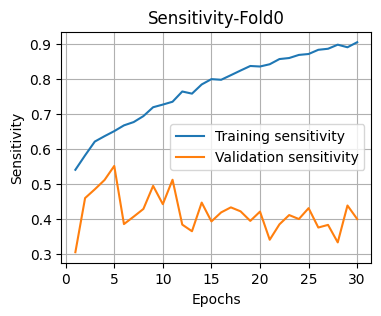

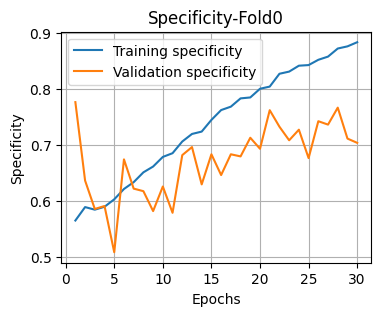

In [40]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [41]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  950  370  53  29     0.353659     0.719697   0.072682  0.120582  0.068429   

    ROC_auc  
0  0.552393


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     950.0  370.0  53.0  29.0     0.353659     0.719697   0.072682  0.120582   
mean  950.0  370.0  53.0  29.0     0.353700     0.719700   0.072700  0.120600   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.068429  0.552393  
mean  0.068400  0.552400  
std        NaN       NaN

### Mask 0.5 (Dropout 0.5; Reg_L2=1e-2)

In [42]:
Dropout = 0.5
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50

MASK_RATE = 0.5


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 14s - 85ms/step - loss: 2.8274 - roc_auc: 0.5199 - sensitivity: 0.5101 - specificity: 0.5084 - val_loss: 2.3632 - val_roc_auc: 0.5139 - val_sensitivity: 0.3371 - val_specificity: 0.6576
Epoch 2/50
170/170 - 4s - 26ms/step - loss: 2.1790 - roc_auc: 0.5269 - sensitivity: 0.5114 - specificity: 0.5332 - val_loss: 1.8981 - val_roc_auc: 0.5264 - val_sensitivity: 0.2121 - val_specificity: 0.7879
Epoch 3/50
170/170 - 4s - 25ms/step - loss: 1.7317 - roc_auc: 0.5332 - sensitivity: 0.5006 - specificity: 0.5504 - val_loss: 1.5336 - val_roc_auc: 0.5405 - val_sensitivity: 0.1841 - val_specificity: 0.8273
Epoch 4/50
170/170 - 4s - 26ms/step - loss: 1.4045 - roc_auc: 0.5412 - sensitivity: 0.5132 - specificity: 0.5454 - val_loss: 1.2699 - val_roc_auc: 0.5547 - val_sensitivity: 0.1417 - val_specificity: 0.8841
Epoch 5/50
170/170 - 5s - 31ms/step - loss: 1.1818 - roc_auc: 0.5371 - sensitivity: 0.5295 - specificity: 0.5226 - val_loss: 1.0855 - val_roc_auc: 0.5604 - val_sensitivit

Metric       Value
0   True Negatives  764.000000
1  False Positives  556.000000
2  False Negatives   36.000000
3   True Positives   46.000000
4      Sensitivity    0.560976
5      Specificity    0.578788
6        Precision    0.076412
7         F1 Score    0.134503
8           PR AUC    0.069775
9          ROC AUC    0.589486

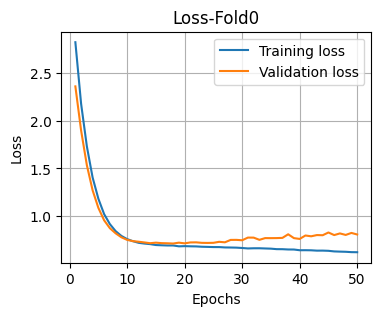

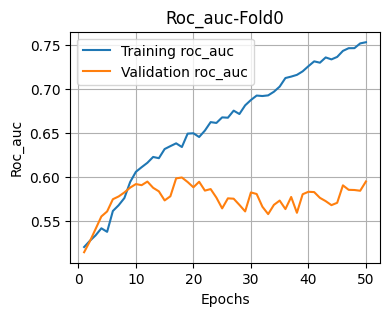

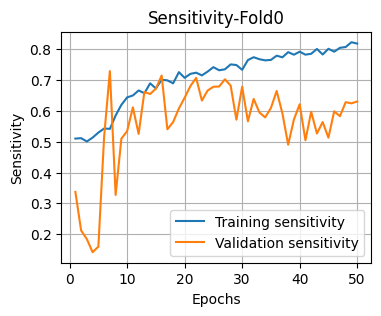

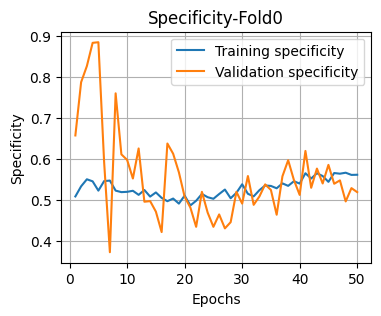

In [43]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [44]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.5 Dropout 0.5 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  764  556  36  46     0.560976     0.578788   0.076412  0.134503  0.069775   

    ROC_auc  
0  0.589486


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     764.0  556.0  36.0  46.0     0.560976     0.578788   0.076412  0.134503   
mean  764.0  556.0  36.0  46.0     0.561000     0.578800   0.076400  0.134500   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.069775  0.589486  
mean  0.069800  0.589500  
std        NaN       NaN

### Mask 0.5 (Dropout 0.5; Reg_L2=1e-4)

In [45]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50

MASK_RATE = 0.5


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 18s - 105ms/step - loss: 0.9247 - roc_auc: 0.5270 - sensitivity: 0.5256 - specificity: 0.5164 - val_loss: 0.7301 - val_roc_auc: 0.4968 - val_sensitivity: 0.4735 - val_specificity: 0.5144
Epoch 2/50
170/170 - 6s - 38ms/step - loss: 0.7591 - roc_auc: 0.5406 - sensitivity: 0.5500 - specificity: 0.5112 - val_loss: 0.7160 - val_roc_auc: 0.5247 - val_sensitivity: 0.3856 - val_specificity: 0.6189
Epoch 3/50
170/170 - 6s - 35ms/step - loss: 0.7315 - roc_auc: 0.5431 - sensitivity: 0.5417 - specificity: 0.5175 - val_loss: 0.7130 - val_roc_auc: 0.5394 - val_sensitivity: 0.8167 - val_specificity: 0.2803
Epoch 4/50
170/170 - 6s - 37ms/step - loss: 0.7165 - roc_auc: 0.5620 - sensitivity: 0.5738 - specificity: 0.5134 - val_loss: 0.7108 - val_roc_auc: 0.5346 - val_sensitivity: 0.5311 - val_specificity: 0.4652
Epoch 5/50
170/170 - 6s - 36ms/step - loss: 0.7097 - roc_auc: 0.5731 - sensitivity: 0.5546 - specificity: 0.5435 - val_loss: 0.7136 - val_roc_auc: 0.5363 - val_sensitivi

Metric        Value
0   True Negatives  1063.000000
1  False Positives   257.000000
2  False Negatives    62.000000
3   True Positives    20.000000
4      Sensitivity     0.243902
5      Specificity     0.805303
6        Precision     0.072202
7         F1 Score     0.111421
8           PR AUC     0.066059
9          ROC AUC     0.547727

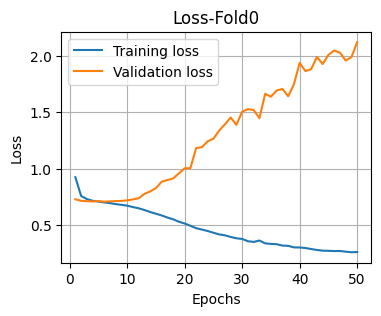

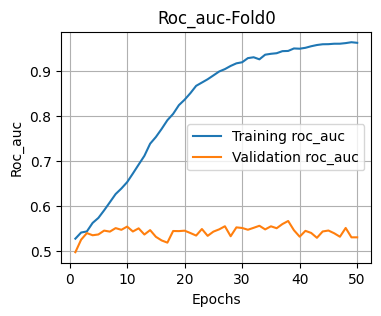

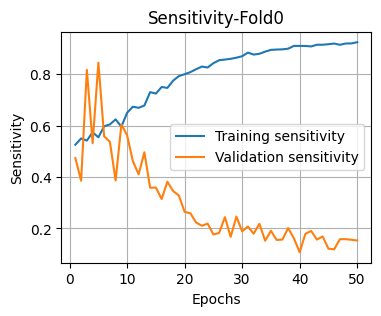

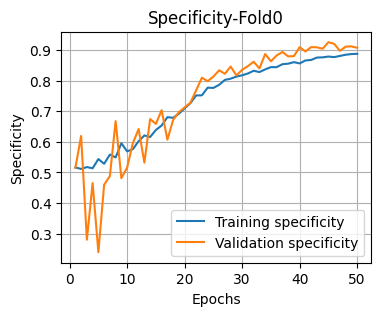

In [46]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))

    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  generate mask
    train_df.loc[:, 'Mask'] = train_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_df.loc[:, 'Mask'] = val_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [47]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  1063  257  62  20     0.243902     0.805303   0.072202  0.111421  0.066059   

    ROC_auc  
0  0.547727


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  \
0     1063.0  257.0  62.0  20.0     0.243902     0.805303   0.072202   
mean  1063.0  257.0  62.0  20.0     0.243900     0.805300   0.072200   
std      NaN    NaN   NaN   NaN          NaN          NaN        NaN   

      f1_score    PR_auc   ROC_auc  
0     0.111421  0.066059  0.547727  
mean  0.111400  0.066100  0.547700  
std        NaN       NaN       NaN

### Mask 0.5 (Dropout 0.7; Reg_L2=1e-2)

In [48]:
Dropout = 0.7
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50

MASK_RATE = 0.5


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 17s - 102ms/step - loss: 3.2004 - roc_auc: 0.5058 - sensitivity: 0.4970 - specificity: 0.5080 - val_loss: 2.5167 - val_roc_auc: 0.5253 - val_sensitivity: 0.6121 - val_specificity: 0.4197
Epoch 2/50
170/170 - 6s - 36ms/step - loss: 2.5001 - roc_auc: 0.5169 - sensitivity: 0.5114 - specificity: 0.5084 - val_loss: 2.1693 - val_roc_auc: 0.5335 - val_sensitivity: 0.8394 - val_specificity: 0.2030
Epoch 3/50
170/170 - 6s - 37ms/step - loss: 2.0738 - roc_auc: 0.5122 - sensitivity: 0.5062 - specificity: 0.5167 - val_loss: 1.8444 - val_roc_auc: 0.5365 - val_sensitivity: 0.6417 - val_specificity: 0.4106
Epoch 4/50
170/170 - 6s - 37ms/step - loss: 1.7342 - roc_auc: 0.5229 - sensitivity: 0.5291 - specificity: 0.5075 - val_loss: 1.5702 - val_roc_auc: 0.5454 - val_sensitivity: 0.9356 - val_specificity: 0.1023
Epoch 5/50
170/170 - 6s - 36ms/step - loss: 1.4768 - roc_auc: 0.5148 - sensitivity: 0.5042 - specificity: 0.5147 - val_loss: 1.3500 - val_roc_auc: 0.5439 - val_sensitivi

Metric       Value
0   True Negatives  623.000000
1  False Positives  697.000000
2  False Negatives   28.000000
3   True Positives   54.000000
4      Sensitivity    0.658537
5      Specificity    0.471970
6        Precision    0.071904
7         F1 Score    0.129652
8           PR AUC    0.067471
9          ROC AUC    0.573023

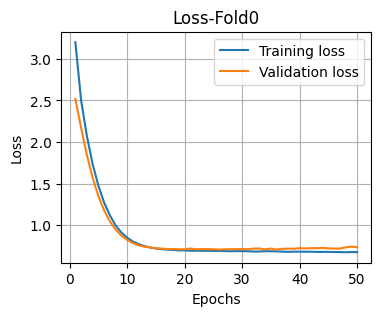

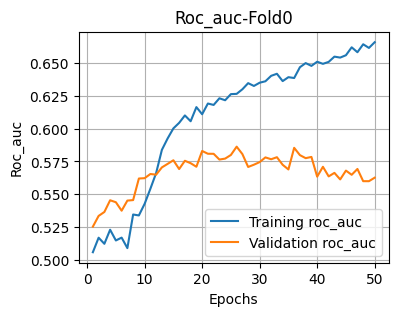

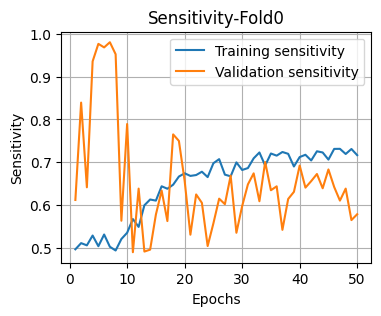

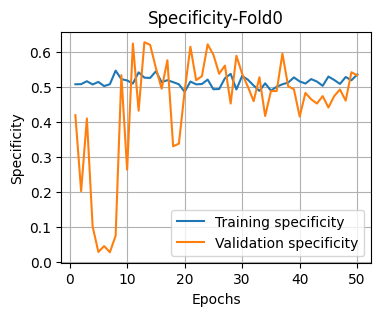

In [49]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [50]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.5 Dropout 0.7 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  623  697  28  54     0.658537      0.47197   0.071904  0.129652  0.067471   

    ROC_auc  
0  0.573023


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     623.0  697.0  28.0  54.0     0.658537      0.47197   0.071904  0.129652   
mean  623.0  697.0  28.0  54.0     0.658500      0.47200   0.071900  0.129700   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.067471  0.573023  
mean  0.067500  0.573000  
std        NaN       NaN

### Mask 0.5 (Dropout 0.7; Reg_L2=1e-4)

In [51]:
Dropout = 0.7
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50

MASK_RATE = 0.5


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 14s - 83ms/step - loss: 1.2480 - roc_auc: 0.5006 - sensitivity: 0.5134 - specificity: 0.4809 - val_loss: 0.7231 - val_roc_auc: 0.5178 - val_sensitivity: 0.2712 - val_specificity: 0.7591
Epoch 2/50
170/170 - 4s - 26ms/step - loss: 0.8856 - roc_auc: 0.5063 - sensitivity: 0.4901 - specificity: 0.5104 - val_loss: 0.7141 - val_roc_auc: 0.5230 - val_sensitivity: 0.4492 - val_specificity: 0.5864
Epoch 3/50
170/170 - 4s - 24ms/step - loss: 0.7821 - roc_auc: 0.5122 - sensitivity: 0.5121 - specificity: 0.5045 - val_loss: 0.7142 - val_roc_auc: 0.5238 - val_sensitivity: 0.5856 - val_specificity: 0.4508
Epoch 4/50
170/170 - 4s - 25ms/step - loss: 0.7460 - roc_auc: 0.5204 - sensitivity: 0.5213 - specificity: 0.5138 - val_loss: 0.7142 - val_roc_auc: 0.5257 - val_sensitivity: 0.6432 - val_specificity: 0.3992
Epoch 5/50
170/170 - 4s - 26ms/step - loss: 0.7324 - roc_auc: 0.5204 - sensitivity: 0.5079 - specificity: 0.5263 - val_loss: 0.7141 - val_roc_auc: 0.5250 - val_sensitivit

Metric       Value
0   True Negatives  720.000000
1  False Positives  600.000000
2  False Negatives   31.000000
3   True Positives   51.000000
4      Sensitivity    0.621951
5      Specificity    0.545455
6        Precision    0.078341
7         F1 Score    0.139154
8           PR AUC    0.068933
9          ROC AUC    0.583112

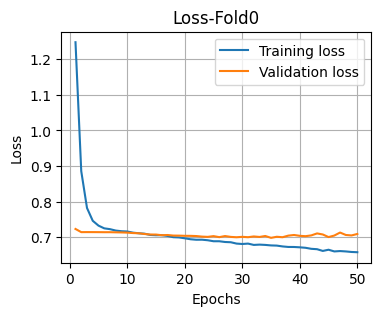

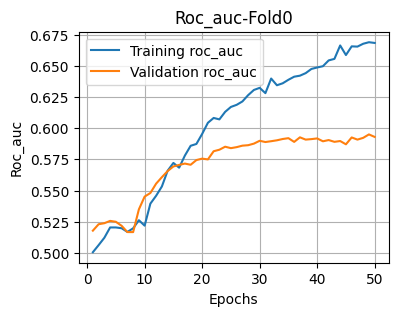

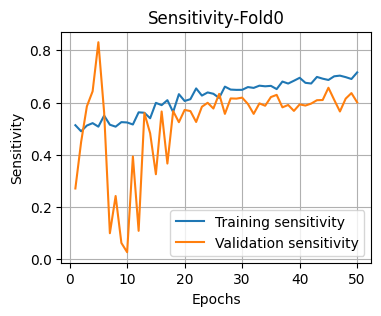

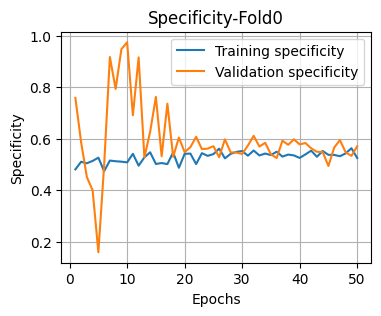

In [52]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [53]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0.7 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  720  600  31  51     0.621951     0.545455   0.078341  0.139154  0.068933   

    ROC_auc  
0  0.583112


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     720.0  600.0  31.0  51.0     0.621951     0.545455   0.078341  0.139154   
mean  720.0  600.0  31.0  51.0     0.622000     0.545500   0.078300  0.139200   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.068933  0.583112  
mean  0.068900  0.583100  
std        NaN       NaN

### Mask 0.5 (Dropout 0.9; Reg_L2=1e-2)

In [61]:
Dropout = 0.9
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 150
PATIENCE_ES  = 50

MASK_RATE = 0.5


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/150
170/170 - 15s - 86ms/step - loss: 4.0237 - roc_auc: 0.4957 - sensitivity: 0.4565 - specificity: 0.5322 - val_loss: 2.7036 - val_roc_auc: 0.5240 - val_sensitivity: 0.1667 - val_specificity: 0.8697
Epoch 2/150
170/170 - 5s - 28ms/step - loss: 3.1564 - roc_auc: 0.5052 - sensitivity: 0.4639 - specificity: 0.5513 - val_loss: 2.4655 - val_roc_auc: 0.5103 - val_sensitivity: 0.0508 - val_specificity: 0.9477
Epoch 3/150
170/170 - 5s - 27ms/step - loss: 2.6067 - roc_auc: 0.5041 - sensitivity: 0.4849 - specificity: 0.5219 - val_loss: 2.2458 - val_roc_auc: 0.4938 - val_sensitivity: 0.0038 - val_specificity: 0.9939
Epoch 4/150
170/170 - 5s - 28ms/step - loss: 2.2169 - roc_auc: 0.5043 - sensitivity: 0.5127 - specificity: 0.5003 - val_loss: 2.0188 - val_roc_auc: 0.5098 - val_sensitivity: 0.0061 - val_specificity: 0.9886
Epoch 5/150
170/170 - 4s - 24ms/step - loss: 1.9466 - roc_auc: 0.5005 - sensitivity: 0.5371 - specificity: 0.4585 - val_loss: 1.8088 - val_roc_auc: 0.5265 - val_sensi

Metric       Value
0   True Negatives  814.000000
1  False Positives  506.000000
2  False Negatives   36.000000
3   True Positives   46.000000
4      Sensitivity    0.560976
5      Specificity    0.616667
6        Precision    0.083333
7         F1 Score    0.145110
8           PR AUC    0.072909
9          ROC AUC    0.592544

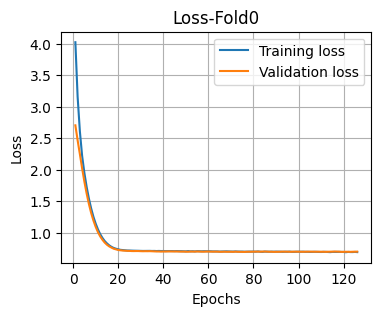

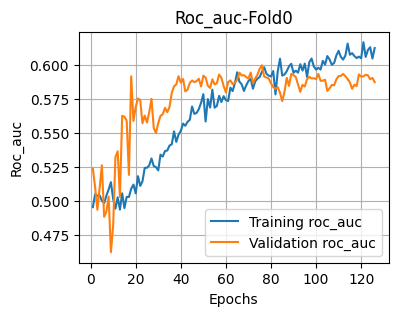

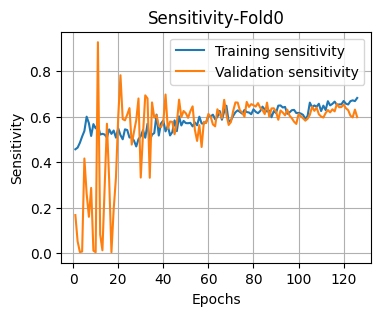

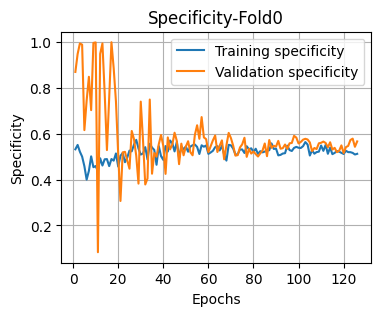

In [62]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [63]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.5 Dropout 0.9 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  814  506  36  46     0.560976     0.616667   0.083333   0.14511  0.072909   

    ROC_auc  
0  0.592544


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     814.0  506.0  36.0  46.0     0.560976     0.616667   0.083333   0.14511   
mean  814.0  506.0  36.0  46.0     0.561000     0.616700   0.083300   0.14510   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.072909  0.592544  
mean  0.072900  0.592500  
std        NaN       NaN

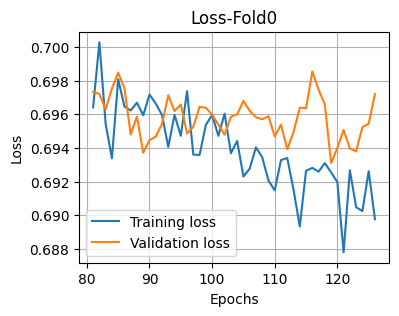

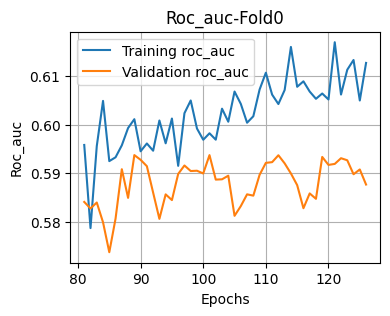

In [64]:
plot_learning_curves(history,
                     name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc',
                                                        #  'sensitivity', 'specificity'
                                                         ],
                     init_index=80)


### Mask 0.5 (Dropout 0.9; Reg_L2=1e-4)

In [65]:
Dropout = 0.9
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 150
PATIENCE_ES  = 50

MASK_RATE = 0.5


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/150
170/170 - 17s - 98ms/step - loss: 2.2092 - roc_auc: 0.5077 - sensitivity: 0.4870 - specificity: 0.5197 - val_loss: 0.7828 - val_roc_auc: 0.5203 - val_sensitivity: 0.4773 - val_specificity: 0.5568
Epoch 2/150
170/170 - 5s - 31ms/step - loss: 1.4463 - roc_auc: 0.5077 - sensitivity: 0.5156 - specificity: 0.4999 - val_loss: 0.7256 - val_roc_auc: 0.5157 - val_sensitivity: 0.4091 - val_specificity: 0.6038
Epoch 3/150
170/170 - 5s - 29ms/step - loss: 1.0659 - roc_auc: 0.4929 - sensitivity: 0.4968 - specificity: 0.4912 - val_loss: 0.7160 - val_roc_auc: 0.5200 - val_sensitivity: 0.4333 - val_specificity: 0.5818
Epoch 4/150
170/170 - 5s - 29ms/step - loss: 0.8493 - roc_auc: 0.4963 - sensitivity: 0.5005 - specificity: 0.5014 - val_loss: 0.7153 - val_roc_auc: 0.5202 - val_sensitivity: 0.3417 - val_specificity: 0.6598
Epoch 5/150
170/170 - 5s - 29ms/step - loss: 0.7617 - roc_auc: 0.5047 - sensitivity: 0.4957 - specificity: 0.5093 - val_loss: 0.7149 - val_roc_auc: 0.5326 - val_sensi

Metric       Value
0   True Negatives  731.000000
1  False Positives  589.000000
2  False Negatives   32.000000
3   True Positives   50.000000
4      Sensitivity    0.609756
5      Specificity    0.553788
6        Precision    0.078247
7         F1 Score    0.138696
8           PR AUC    0.067908
9          ROC AUC    0.576681

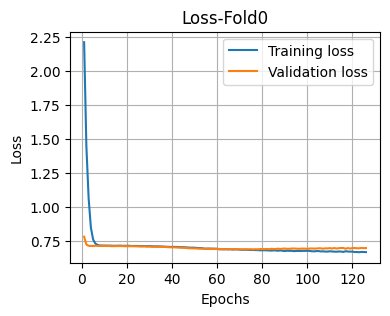

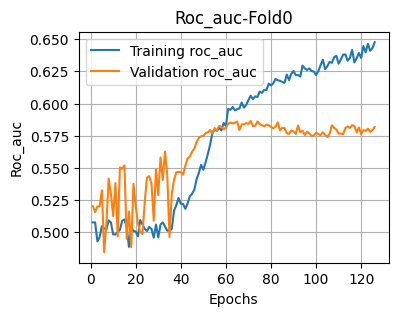

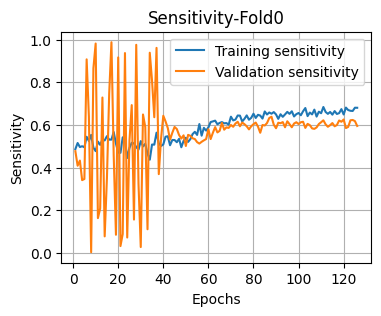

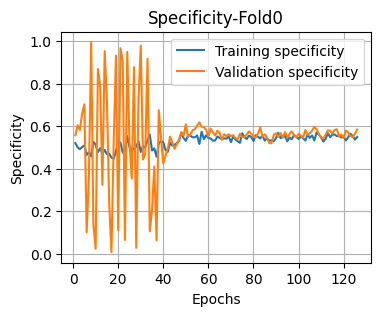

In [66]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [67]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.5 Dropout 0.9 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  731  589  32  50     0.609756     0.553788   0.078247  0.138696  0.067908   

    ROC_auc  
0  0.576681


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     731.0  589.0  32.0  50.0     0.609756     0.553788   0.078247  0.138696   
mean  731.0  589.0  32.0  50.0     0.609800     0.553800   0.078200  0.138700   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.067908  0.576681  
mean  0.067900  0.576700  
std        NaN       NaN

## Mask 0.3

In [68]:
MASK_RATE = 0.3

### Dropout 0; Reg_L2=1e-2

In [69]:
Dropout = 0
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 30
PATIENCE_ES  = 30


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/30
170/170 - 13s - 79ms/step - loss: 2.5566 - roc_auc: 0.5558 - sensitivity: 0.5502 - specificity: 0.5467 - val_loss: 2.1989 - val_roc_auc: 0.5329 - val_sensitivity: 0.4121 - val_specificity: 0.6205
Epoch 2/30
170/170 - 4s - 25ms/step - loss: 1.8847 - roc_auc: 0.6099 - sensitivity: 0.5905 - specificity: 0.5753 - val_loss: 1.6770 - val_roc_auc: 0.5493 - val_sensitivity: 0.4220 - val_specificity: 0.6424
Epoch 3/30
170/170 - 4s - 24ms/step - loss: 1.4506 - roc_auc: 0.6394 - sensitivity: 0.6197 - specificity: 0.5855 - val_loss: 1.3663 - val_roc_auc: 0.5547 - val_sensitivity: 0.2568 - val_specificity: 0.7727
Epoch 4/30
170/170 - 4s - 26ms/step - loss: 1.1811 - roc_auc: 0.6611 - sensitivity: 0.6452 - specificity: 0.5916 - val_loss: 1.1346 - val_roc_auc: 0.5763 - val_sensitivity: 0.5545 - val_specificity: 0.5530
Epoch 5/30
170/170 - 4s - 24ms/step - loss: 1.0132 - roc_auc: 0.6820 - sensitivity: 0.6616 - specificity: 0.5990 - val_loss: 1.0665 - val_roc_auc: 0.5329 - val_sensitivit

Metric       Value
0   True Negatives  944.000000
1  False Positives  376.000000
2  False Negatives   51.000000
3   True Positives   31.000000
4      Sensitivity    0.378049
5      Specificity    0.715152
6        Precision    0.076167
7         F1 Score    0.126789
8           PR AUC    0.075534
9          ROC AUC    0.569614

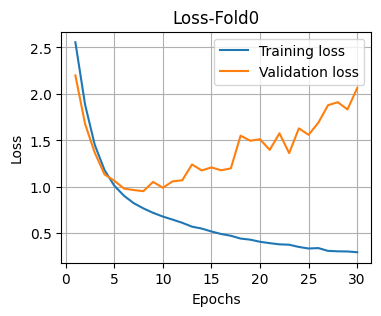

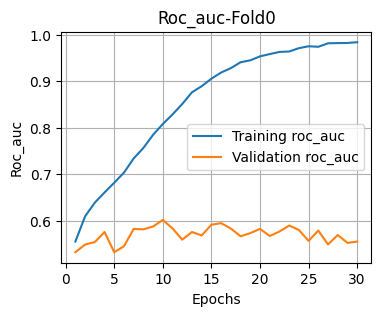

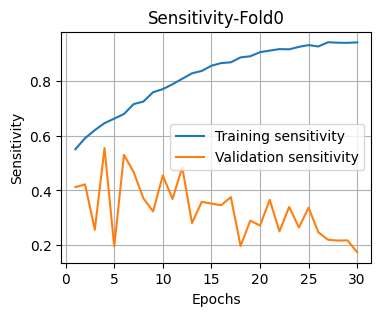

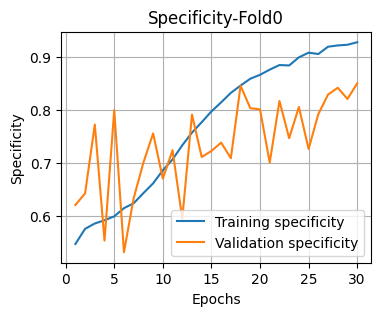

In [70]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [71]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.3 Dropout 0 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  944  376  51  31     0.378049     0.715152   0.076167  0.126789  0.075534   

    ROC_auc  
0  0.569614


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     944.0  376.0  51.0  31.0     0.378049     0.715152   0.076167  0.126789   
mean  944.0  376.0  51.0  31.0     0.378000     0.715200   0.076200  0.126800   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.075534  0.569614  
mean  0.075500  0.569600  
std        NaN       NaN

### Dropout 0; Reg_L2=1e-4

In [72]:
Dropout = 0
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 30
PATIENCE_ES  = 30


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/30
170/170 - 14s - 80ms/step - loss: 0.7733 - roc_auc: 0.5591 - sensitivity: 0.5389 - specificity: 0.5585 - val_loss: 0.7386 - val_roc_auc: 0.5415 - val_sensitivity: 0.5765 - val_specificity: 0.4871
Epoch 2/30
170/170 - 4s - 23ms/step - loss: 0.6933 - roc_auc: 0.6228 - sensitivity: 0.5986 - specificity: 0.5748 - val_loss: 0.7339 - val_roc_auc: 0.5392 - val_sensitivity: 0.5576 - val_specificity: 0.5106
Epoch 3/30
170/170 - 4s - 23ms/step - loss: 0.6783 - roc_auc: 0.6499 - sensitivity: 0.6248 - specificity: 0.5949 - val_loss: 0.7378 - val_roc_auc: 0.5507 - val_sensitivity: 0.4250 - val_specificity: 0.6235
Epoch 4/30
170/170 - 4s - 24ms/step - loss: 0.6641 - roc_auc: 0.6754 - sensitivity: 0.6470 - specificity: 0.6126 - val_loss: 0.7641 - val_roc_auc: 0.5522 - val_sensitivity: 0.2659 - val_specificity: 0.7606
Epoch 5/30
170/170 - 4s - 23ms/step - loss: 0.6501 - roc_auc: 0.6958 - sensitivity: 0.6559 - specificity: 0.6193 - val_loss: 0.7515 - val_roc_auc: 0.5699 - val_sensitivit

Metric       Value
0   True Negatives  534.000000
1  False Positives  786.000000
2  False Negatives   21.000000
3   True Positives   61.000000
4      Sensitivity    0.743902
5      Specificity    0.404545
6        Precision    0.072019
7         F1 Score    0.131324
8           PR AUC    0.073976
9          ROC AUC    0.590632

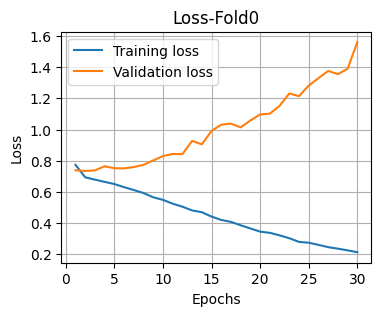

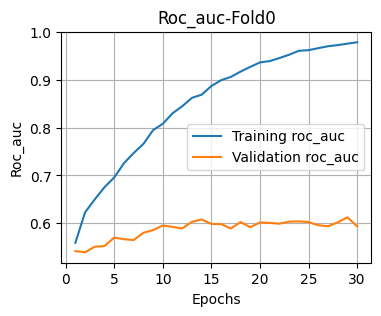

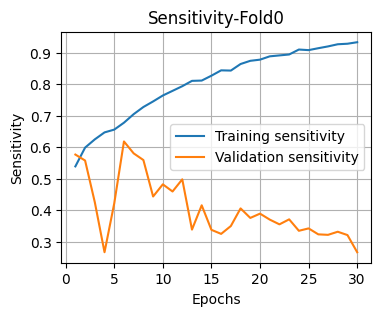

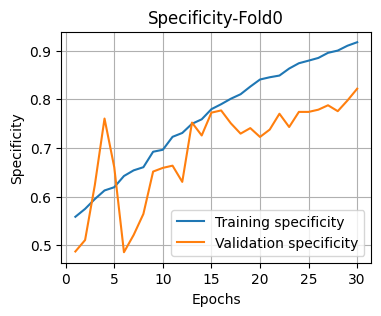

In [73]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [74]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.3 Dropout 0 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  534  786  21  61     0.743902     0.404545   0.072019  0.131324  0.073976   

    ROC_auc  
0  0.590632


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     534.0  786.0  21.0  61.0     0.743902     0.404545   0.072019  0.131324   
mean  534.0  786.0  21.0  61.0     0.743900     0.404500   0.072000  0.131300   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.073976  0.590632  
mean  0.074000  0.590600  
std        NaN       NaN

### Dropout 0.5; Reg_L2=1e-2

In [75]:
Dropout = 0.5
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 14s - 80ms/step - loss: 2.8522 - roc_auc: 0.5166 - sensitivity: 0.5171 - specificity: 0.5064 - val_loss: 2.3805 - val_roc_auc: 0.5541 - val_sensitivity: 0.5924 - val_specificity: 0.4917
Epoch 2/50
170/170 - 4s - 25ms/step - loss: 2.2140 - roc_auc: 0.5223 - sensitivity: 0.5243 - specificity: 0.5043 - val_loss: 1.9224 - val_roc_auc: 0.5650 - val_sensitivity: 0.6894 - val_specificity: 0.4083
Epoch 3/50
170/170 - 4s - 24ms/step - loss: 1.7621 - roc_auc: 0.5324 - sensitivity: 0.5448 - specificity: 0.5010 - val_loss: 1.5601 - val_roc_auc: 0.5541 - val_sensitivity: 0.8189 - val_specificity: 0.2576
Epoch 4/50
170/170 - 4s - 24ms/step - loss: 1.4334 - roc_auc: 0.5308 - sensitivity: 0.5385 - specificity: 0.5090 - val_loss: 1.2903 - val_roc_auc: 0.5618 - val_sensitivity: 0.4803 - val_specificity: 0.6098
Epoch 5/50
170/170 - 4s - 26ms/step - loss: 1.1985 - roc_auc: 0.5387 - sensitivity: 0.5406 - specificity: 0.5173 - val_loss: 1.0987 - val_roc_auc: 0.5703 - val_sensitivit

Metric       Value
0   True Negatives  584.000000
1  False Positives  736.000000
2  False Negatives   27.000000
3   True Positives   55.000000
4      Sensitivity    0.670732
5      Specificity    0.442424
6        Precision    0.069532
7         F1 Score    0.126002
8           PR AUC    0.080078
9          ROC AUC    0.580432

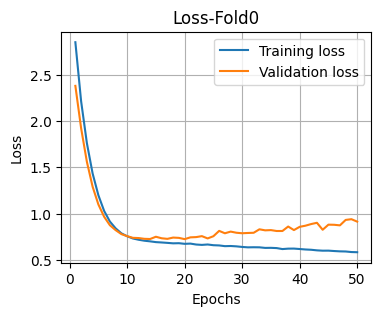

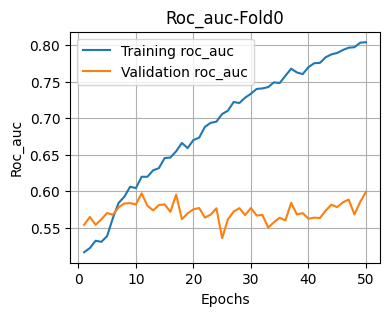

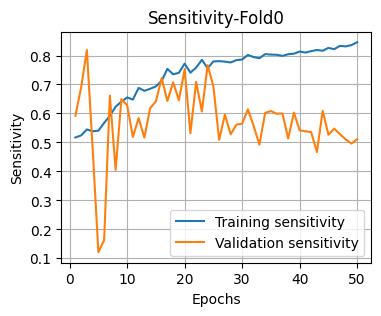

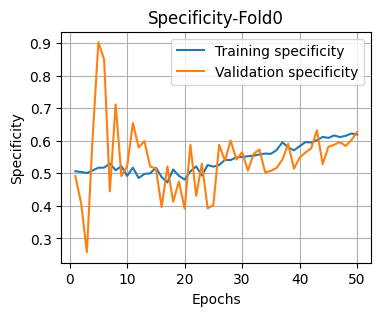

In [76]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [77]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.3 Dropout 0.5 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  584  736  27  55     0.670732     0.442424   0.069532  0.126002  0.080078   

    ROC_auc  
0  0.580432


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     584.0  736.0  27.0  55.0     0.670732     0.442424   0.069532  0.126002   
mean  584.0  736.0  27.0  55.0     0.670700     0.442400   0.069500  0.126000   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.080078  0.580432  
mean  0.080100  0.580400  
std        NaN       NaN

### Dropout 0.5; Reg_L2=1e-4

In [78]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 14s - 80ms/step - loss: 0.9580 - roc_auc: 0.5102 - sensitivity: 0.5167 - specificity: 0.5093 - val_loss: 0.7202 - val_roc_auc: 0.5438 - val_sensitivity: 0.4697 - val_specificity: 0.5917
Epoch 2/50
170/170 - 4s - 24ms/step - loss: 0.7793 - roc_auc: 0.5227 - sensitivity: 0.5149 - specificity: 0.5208 - val_loss: 0.7141 - val_roc_auc: 0.5457 - val_sensitivity: 0.3538 - val_specificity: 0.7053
Epoch 3/50
170/170 - 4s - 23ms/step - loss: 0.7372 - roc_auc: 0.5331 - sensitivity: 0.4994 - specificity: 0.5395 - val_loss: 0.7103 - val_roc_auc: 0.5573 - val_sensitivity: 0.4356 - val_specificity: 0.6402
Epoch 4/50
170/170 - 4s - 25ms/step - loss: 0.7238 - roc_auc: 0.5436 - sensitivity: 0.5396 - specificity: 0.5193 - val_loss: 0.7108 - val_roc_auc: 0.5586 - val_sensitivity: 0.3311 - val_specificity: 0.7318
Epoch 5/50
170/170 - 4s - 24ms/step - loss: 0.7133 - roc_auc: 0.5582 - sensitivity: 0.5391 - specificity: 0.5422 - val_loss: 0.7097 - val_roc_auc: 0.5594 - val_sensitivit

Metric       Value
0   True Negatives  707.000000
1  False Positives  613.000000
2  False Negatives   33.000000
3   True Positives   49.000000
4      Sensitivity    0.597561
5      Specificity    0.535606
6        Precision    0.074018
7         F1 Score    0.131720
8           PR AUC    0.070820
9          ROC AUC    0.569799

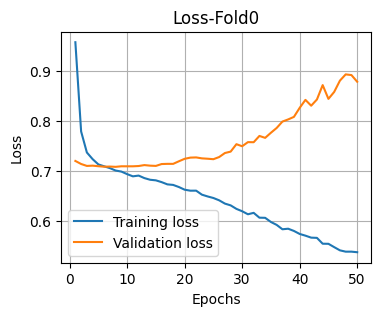

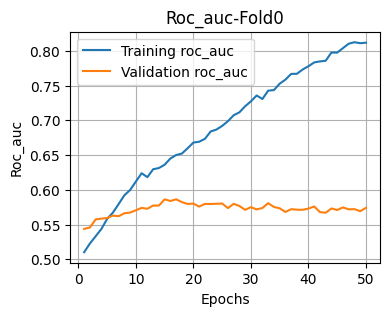

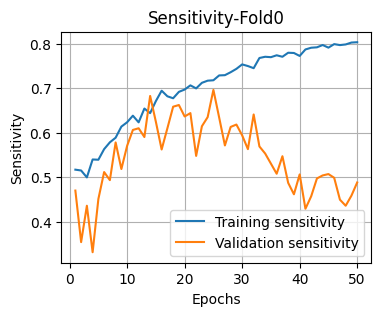

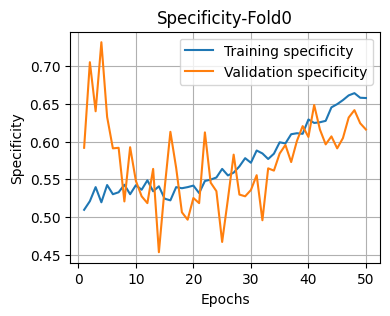

In [79]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [80]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.3 Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score   PR_auc  \
0  707  613  33  49     0.597561     0.535606   0.074018   0.13172  0.07082   

    ROC_auc  
0  0.569799


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     707.0  613.0  33.0  49.0     0.597561     0.535606   0.074018   0.13172   
mean  707.0  613.0  33.0  49.0     0.597600     0.535600   0.074000   0.13170   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

       PR_auc   ROC_auc  
0     0.07082  0.569799  
mean  0.07080  0.569800  
std       NaN       NaN

### Dropout 0.7; Reg_L2=1e-2

In [81]:
Dropout = 0.7
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 13s - 78ms/step - loss: 3.2623 - roc_auc: 0.5027 - sensitivity: 0.4960 - specificity: 0.5025 - val_loss: 2.5554 - val_roc_auc: 0.5396 - val_sensitivity: 0.5098 - val_specificity: 0.5371
Epoch 2/50
170/170 - 4s - 23ms/step - loss: 2.5802 - roc_auc: 0.5215 - sensitivity: 0.5143 - specificity: 0.5180 - val_loss: 2.2171 - val_roc_auc: 0.5425 - val_sensitivity: 0.2568 - val_specificity: 0.7803
Epoch 3/50
170/170 - 4s - 23ms/step - loss: 2.1417 - roc_auc: 0.5137 - sensitivity: 0.5101 - specificity: 0.5091 - val_loss: 1.9052 - val_roc_auc: 0.5479 - val_sensitivity: 0.6735 - val_specificity: 0.3985
Epoch 4/50
170/170 - 4s - 24ms/step - loss: 1.8055 - roc_auc: 0.5184 - sensitivity: 0.5250 - specificity: 0.5075 - val_loss: 1.6341 - val_roc_auc: 0.5391 - val_sensitivity: 0.3636 - val_specificity: 0.6917
Epoch 5/50
170/170 - 4s - 23ms/step - loss: 1.5371 - roc_auc: 0.5212 - sensitivity: 0.5095 - specificity: 0.5193 - val_loss: 1.4073 - val_roc_auc: 0.5620 - val_sensitivit

Metric       Value
0   True Negatives  563.000000
1  False Positives  757.000000
2  False Negatives   24.000000
3   True Positives   58.000000
4      Sensitivity    0.707317
5      Specificity    0.426515
6        Precision    0.071166
7         F1 Score    0.129320
8           PR AUC    0.066440
9          ROC AUC    0.565965

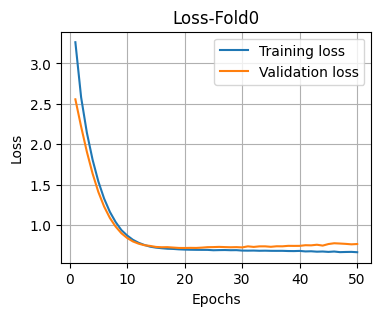

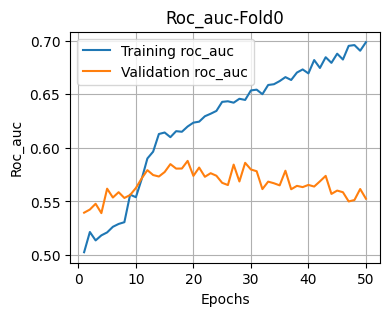

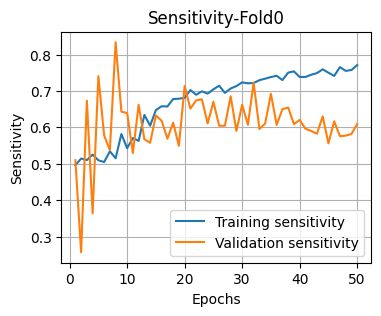

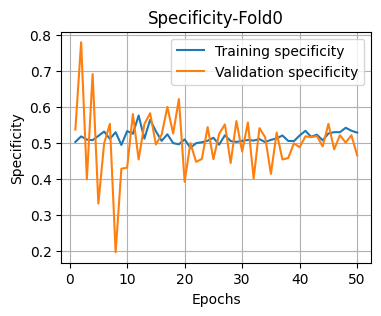

In [82]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [83]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.3 Dropout 0.7 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score   PR_auc  \
0  563  757  24  58     0.707317     0.426515   0.071166   0.12932  0.06644   

    ROC_auc  
0  0.565965


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     563.0  757.0  24.0  58.0     0.707317     0.426515   0.071166   0.12932   
mean  563.0  757.0  24.0  58.0     0.707300     0.426500   0.071200   0.12930   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

       PR_auc   ROC_auc  
0     0.06644  0.565965  
mean  0.06640  0.566000  
std       NaN       NaN

### Dropout 0.7; Reg_L2=1e-4

In [84]:
Dropout = 0.7
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50



=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 14s - 80ms/step - loss: 1.2968 - roc_auc: 0.5153 - sensitivity: 0.5136 - specificity: 0.5003 - val_loss: 0.7372 - val_roc_auc: 0.5236 - val_sensitivity: 0.5886 - val_specificity: 0.4553
Epoch 2/50
170/170 - 4s - 24ms/step - loss: 0.9284 - roc_auc: 0.5127 - sensitivity: 0.5075 - specificity: 0.5091 - val_loss: 0.7183 - val_roc_auc: 0.5164 - val_sensitivity: 0.3894 - val_specificity: 0.6386
Epoch 3/50
170/170 - 4s - 26ms/step - loss: 0.7940 - roc_auc: 0.5291 - sensitivity: 0.5140 - specificity: 0.5250 - val_loss: 0.7164 - val_roc_auc: 0.5149 - val_sensitivity: 0.1848 - val_specificity: 0.8136
Epoch 4/50
170/170 - 4s - 23ms/step - loss: 0.7554 - roc_auc: 0.5249 - sensitivity: 0.5204 - specificity: 0.5175 - val_loss: 0.7156 - val_roc_auc: 0.5099 - val_sensitivity: 0.1447 - val_specificity: 0.8439
Epoch 5/50
170/170 - 4s - 23ms/step - loss: 0.7407 - roc_auc: 0.5148 - sensitivity: 0.4942 - specificity: 0.5265 - val_loss: 0.7144 - val_roc_auc: 0.5239 - val_sensitivit

Metric       Value
0   True Negatives  750.000000
1  False Positives  570.000000
2  False Negatives   36.000000
3   True Positives   46.000000
4      Sensitivity    0.560976
5      Specificity    0.568182
6        Precision    0.074675
7         F1 Score    0.131805
8           PR AUC    0.068028
9          ROC AUC    0.573143

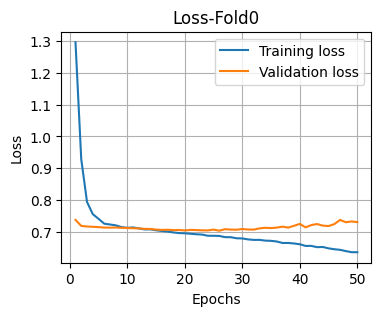

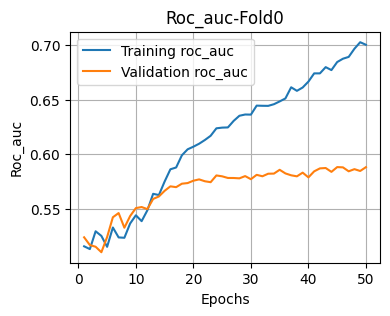

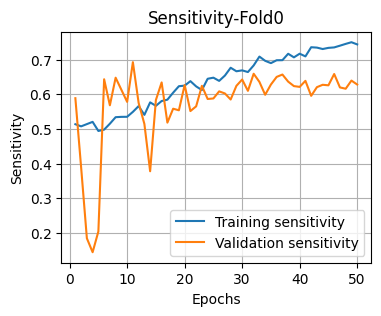

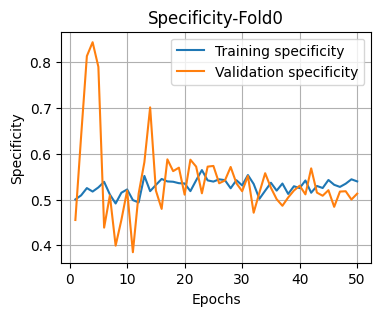

In [85]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [86]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.3 Dropout 0.7 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  750  570  36  46     0.560976     0.568182   0.074675  0.131805  0.068028   

    ROC_auc  
0  0.573143


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     750.0  570.0  36.0  46.0     0.560976     0.568182   0.074675  0.131805   
mean  750.0  570.0  36.0  46.0     0.561000     0.568200   0.074700  0.131800   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.068028  0.573143  
mean  0.068000  0.573100  
std        NaN       NaN

### Dropout 0.9; Reg_L2=1e-2

In [87]:
Dropout = 0.9
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 150
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/150
170/170 - 14s - 80ms/step - loss: 3.9118 - roc_auc: 0.5120 - sensitivity: 0.4872 - specificity: 0.5271 - val_loss: 2.6696 - val_roc_auc: 0.5573 - val_sensitivity: 0.4265 - val_specificity: 0.6568
Epoch 2/150
170/170 - 4s - 23ms/step - loss: 3.1756 - roc_auc: 0.5019 - sensitivity: 0.4783 - specificity: 0.5221 - val_loss: 2.4741 - val_roc_auc: 0.5494 - val_sensitivity: 0.1311 - val_specificity: 0.9061
Epoch 3/150
170/170 - 4s - 23ms/step - loss: 2.6036 - roc_auc: 0.5118 - sensitivity: 0.4971 - specificity: 0.5217 - val_loss: 2.2597 - val_roc_auc: 0.5290 - val_sensitivity: 0.0356 - val_specificity: 0.9636
Epoch 4/150
170/170 - 4s - 23ms/step - loss: 2.2411 - roc_auc: 0.5051 - sensitivity: 0.5232 - specificity: 0.4892 - val_loss: 2.0417 - val_roc_auc: 0.5099 - val_sensitivity: 0.0045 - val_specificity: 0.9894
Epoch 5/150
170/170 - 4s - 23ms/step - loss: 1.9670 - roc_auc: 0.5020 - sensitivity: 0.5182 - specificity: 0.4888 - val_loss: 1.8305 - val_roc_auc: 0.4923 - val_sensi

Metric       Value
0   True Negatives  654.000000
1  False Positives  666.000000
2  False Negatives   26.000000
3   True Positives   56.000000
4      Sensitivity    0.682927
5      Specificity    0.495455
6        Precision    0.077562
7         F1 Score    0.139303
8           PR AUC    0.075954
9          ROC AUC    0.590567

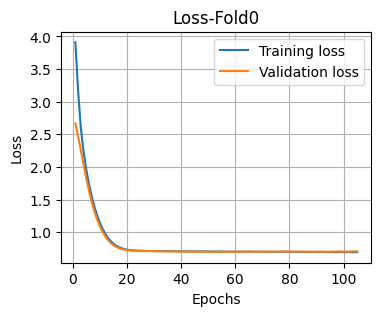

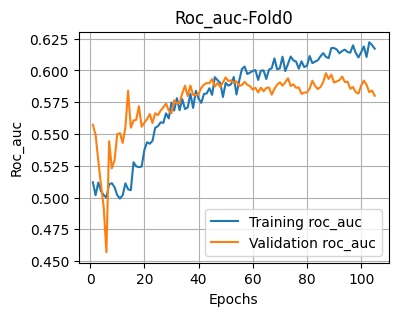

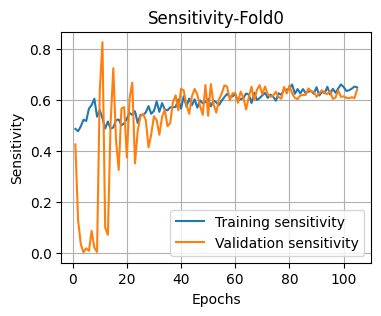

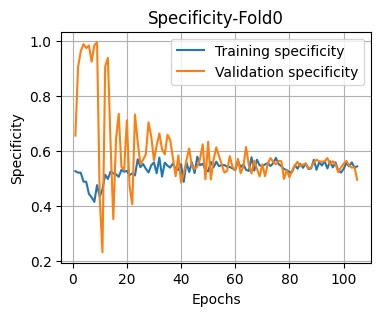

In [88]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [89]:
print('MASK_RATE',MASK_RATE , "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.3 Dropout 0.9 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  654  666  26  56     0.682927     0.495455   0.077562  0.139303  0.075954   

    ROC_auc  
0  0.590567


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     654.0  666.0  26.0  56.0     0.682927     0.495455   0.077562  0.139303   
mean  654.0  666.0  26.0  56.0     0.682900     0.495500   0.077600  0.139300   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.075954  0.590567  
mean  0.076000  0.590600  
std        NaN       NaN

### Dropout 0.9; Reg_L2=1e-4

In [90]:
Dropout = 0.9
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 150
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/150
170/170 - 13s - 77ms/step - loss: 1.8582 - roc_auc: 0.5052 - sensitivity: 0.4896 - specificity: 0.5169 - val_loss: 0.7494 - val_roc_auc: 0.5350 - val_sensitivity: 0.4364 - val_specificity: 0.5856
Epoch 2/150
170/170 - 4s - 23ms/step - loss: 1.2422 - roc_auc: 0.4980 - sensitivity: 0.4866 - specificity: 0.5104 - val_loss: 0.7192 - val_roc_auc: 0.5426 - val_sensitivity: 0.2273 - val_specificity: 0.8098
Epoch 3/150
170/170 - 4s - 23ms/step - loss: 0.9177 - roc_auc: 0.4961 - sensitivity: 0.4840 - specificity: 0.5143 - val_loss: 0.7155 - val_roc_auc: 0.5249 - val_sensitivity: 0.3614 - val_specificity: 0.6674
Epoch 4/150
170/170 - 4s - 24ms/step - loss: 0.7763 - roc_auc: 0.5082 - sensitivity: 0.4990 - specificity: 0.5084 - val_loss: 0.7160 - val_roc_auc: 0.5054 - val_sensitivity: 0.1553 - val_specificity: 0.8492
Epoch 5/150
170/170 - 4s - 23ms/step - loss: 0.7313 - roc_auc: 0.5136 - sensitivity: 0.5313 - specificity: 0.4842 - val_loss: 0.7155 - val_roc_auc: 0.5086 - val_sensi

Metric       Value
0   True Negatives  778.000000
1  False Positives  542.000000
2  False Negatives   33.000000
3   True Positives   49.000000
4      Sensitivity    0.597561
5      Specificity    0.589394
6        Precision    0.082910
7         F1 Score    0.145617
8           PR AUC    0.075197
9          ROC AUC    0.588784

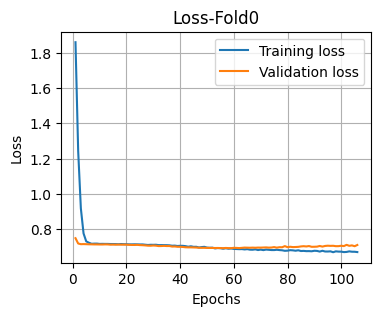

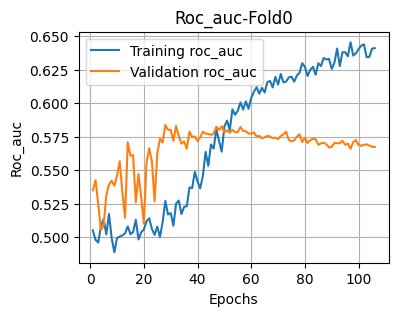

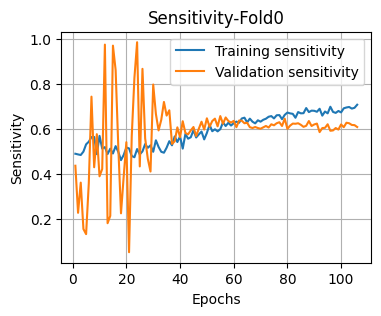

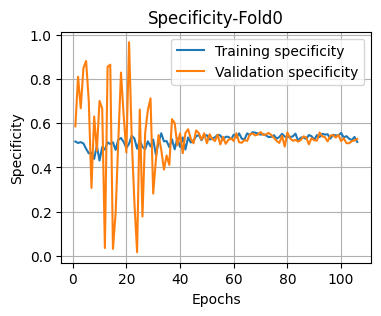

In [91]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [92]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.3 Dropout 0.9 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  778  542  33  49     0.597561     0.589394    0.08291  0.145617  0.075197   

    ROC_auc  
0  0.588784


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     778.0  542.0  33.0  49.0     0.597561     0.589394    0.08291  0.145617   
mean  778.0  542.0  33.0  49.0     0.597600     0.589400    0.08290  0.145600   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.075197  0.588784  
mean  0.075200  0.588800  
std        NaN       NaN

## Mask 0.7

In [93]:
MASK_RATE = 0.7

### Dropout 0; Reg_L2=1e-2

In [94]:
Dropout = 0
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 30
PATIENCE_ES  = 30


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/30
170/170 - 13s - 78ms/step - loss: 2.4206 - roc_auc: 0.5567 - sensitivity: 0.5457 - specificity: 0.5483 - val_loss: 1.9860 - val_roc_auc: 0.5460 - val_sensitivity: 0.5030 - val_specificity: 0.5591
Epoch 2/30
170/170 - 4s - 23ms/step - loss: 1.6724 - roc_auc: 0.6021 - sensitivity: 0.5770 - specificity: 0.5705 - val_loss: 1.4491 - val_roc_auc: 0.5475 - val_sensitivity: 0.4977 - val_specificity: 0.5826
Epoch 3/30
170/170 - 4s - 24ms/step - loss: 1.2588 - roc_auc: 0.6124 - sensitivity: 0.5921 - specificity: 0.5720 - val_loss: 1.1430 - val_roc_auc: 0.5727 - val_sensitivity: 0.5386 - val_specificity: 0.5652
Epoch 4/30
170/170 - 4s - 23ms/step - loss: 1.0309 - roc_auc: 0.6252 - sensitivity: 0.6173 - specificity: 0.5596 - val_loss: 0.9877 - val_roc_auc: 0.5597 - val_sensitivity: 0.5023 - val_specificity: 0.6015
Epoch 5/30
170/170 - 4s - 23ms/step - loss: 0.9027 - roc_auc: 0.6332 - sensitivity: 0.6213 - specificity: 0.5698 - val_loss: 0.9006 - val_roc_auc: 0.5661 - val_sensitivit

Metric       Value
0   True Negatives  735.000000
1  False Positives  585.000000
2  False Negatives   34.000000
3   True Positives   48.000000
4      Sensitivity    0.585366
5      Specificity    0.556818
6        Precision    0.075829
7         F1 Score    0.134266
8           PR AUC    0.074654
9          ROC AUC    0.598688

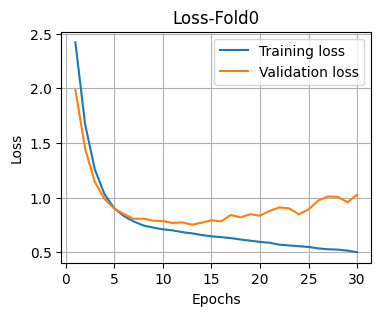

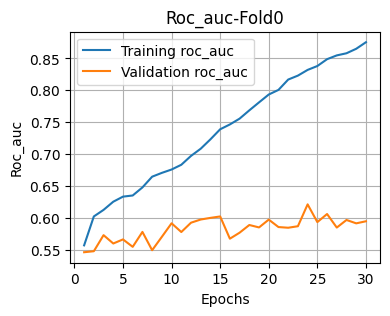

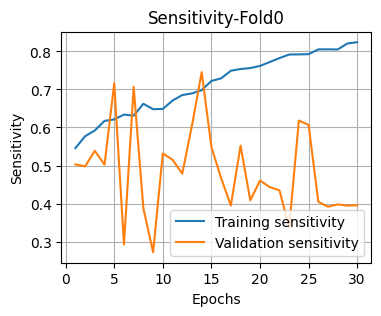

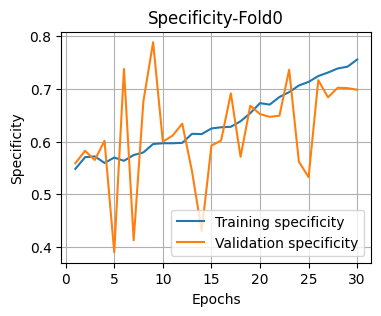

In [95]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [96]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.7 Dropout 0 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  735  585  34  48     0.585366     0.556818   0.075829  0.134266  0.074654   

    ROC_auc  
0  0.598688


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     735.0  585.0  34.0  48.0     0.585366     0.556818   0.075829  0.134266   
mean  735.0  585.0  34.0  48.0     0.585400     0.556800   0.075800  0.134300   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.074654  0.598688  
mean  0.074700  0.598700  
std        NaN       NaN

### Dropout 0; Reg_L2=1e-4

In [97]:
Dropout = 0
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 30
PATIENCE_ES  = 30


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/30
170/170 - 13s - 77ms/step - loss: 0.7321 - roc_auc: 0.5665 - sensitivity: 0.5651 - specificity: 0.5389 - val_loss: 0.7269 - val_roc_auc: 0.5525 - val_sensitivity: 0.3977 - val_specificity: 0.6780
Epoch 2/30
170/170 - 4s - 24ms/step - loss: 0.6968 - roc_auc: 0.6112 - sensitivity: 0.6130 - specificity: 0.5550 - val_loss: 0.7225 - val_roc_auc: 0.5664 - val_sensitivity: 0.3606 - val_specificity: 0.7008
Epoch 3/30
170/170 - 4s - 23ms/step - loss: 0.6885 - roc_auc: 0.6267 - sensitivity: 0.6259 - specificity: 0.5559 - val_loss: 0.7150 - val_roc_auc: 0.5672 - val_sensitivity: 0.5848 - val_specificity: 0.5265
Epoch 4/30
170/170 - 4s - 23ms/step - loss: 0.6808 - roc_auc: 0.6412 - sensitivity: 0.6293 - specificity: 0.5694 - val_loss: 0.7216 - val_roc_auc: 0.5662 - val_sensitivity: 0.4583 - val_specificity: 0.6311
Epoch 5/30
170/170 - 4s - 24ms/step - loss: 0.6731 - roc_auc: 0.6564 - sensitivity: 0.6393 - specificity: 0.5821 - val_loss: 0.7264 - val_roc_auc: 0.5614 - val_sensitivit

Metric       Value
0   True Negatives  787.000000
1  False Positives  533.000000
2  False Negatives   38.000000
3   True Positives   44.000000
4      Sensitivity    0.536585
5      Specificity    0.596212
6        Precision    0.076256
7         F1 Score    0.133536
8           PR AUC    0.078980
9          ROC AUC    0.577411

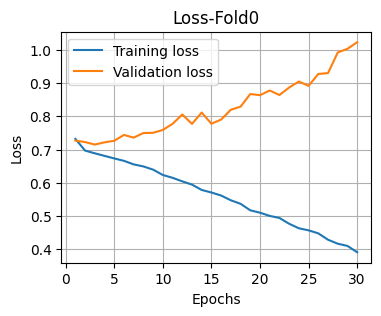

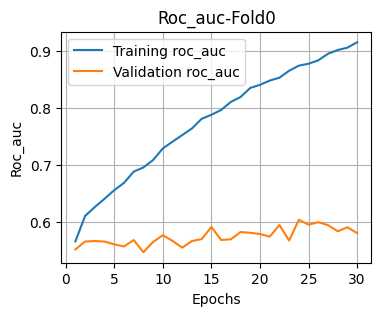

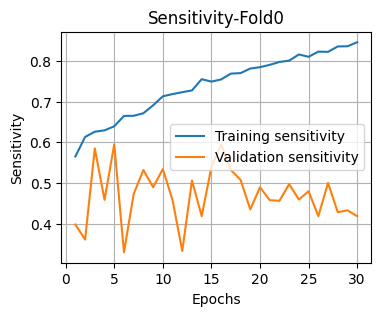

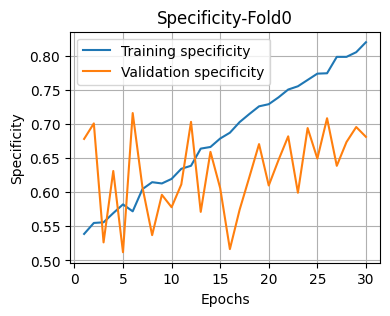

In [98]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [99]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.7 Dropout 0 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score   PR_auc  \
0  787  533  38  44     0.536585     0.596212   0.076256  0.133536  0.07898   

    ROC_auc  
0  0.577411


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     787.0  533.0  38.0  44.0     0.536585     0.596212   0.076256  0.133536   
mean  787.0  533.0  38.0  44.0     0.536600     0.596200   0.076300  0.133500   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

       PR_auc   ROC_auc  
0     0.07898  0.577411  
mean  0.07900  0.577400  
std       NaN       NaN

### Dropout 0.5; Reg_L2=1e-2

In [100]:
Dropout = 0.5
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 13s - 78ms/step - loss: 2.8109 - roc_auc: 0.5189 - sensitivity: 0.5090 - specificity: 0.5160 - val_loss: 2.3020 - val_roc_auc: 0.5581 - val_sensitivity: 0.6848 - val_specificity: 0.3742
Epoch 2/50
170/170 - 4s - 23ms/step - loss: 2.1097 - roc_auc: 0.5275 - sensitivity: 0.5234 - specificity: 0.5182 - val_loss: 1.8235 - val_roc_auc: 0.5633 - val_sensitivity: 0.7485 - val_specificity: 0.3235
Epoch 3/50
170/170 - 4s - 25ms/step - loss: 1.6578 - roc_auc: 0.5272 - sensitivity: 0.5236 - specificity: 0.5075 - val_loss: 1.4636 - val_roc_auc: 0.5657 - val_sensitivity: 0.4015 - val_specificity: 0.7000
Epoch 4/50
170/170 - 4s - 23ms/step - loss: 1.3442 - roc_auc: 0.5332 - sensitivity: 0.5324 - specificity: 0.5056 - val_loss: 1.2126 - val_roc_auc: 0.5622 - val_sensitivity: 0.6159 - val_specificity: 0.4902
Epoch 5/50
170/170 - 4s - 23ms/step - loss: 1.1283 - roc_auc: 0.5443 - sensitivity: 0.5365 - specificity: 0.5252 - val_loss: 1.0418 - val_roc_auc: 0.5620 - val_sensitivit

Metric       Value
0   True Negatives  795.000000
1  False Positives  525.000000
2  False Negatives   36.000000
3   True Positives   46.000000
4      Sensitivity    0.560976
5      Specificity    0.602273
6        Precision    0.080560
7         F1 Score    0.140888
8           PR AUC    0.074637
9          ROC AUC    0.597579

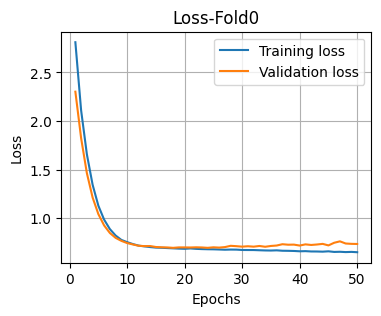

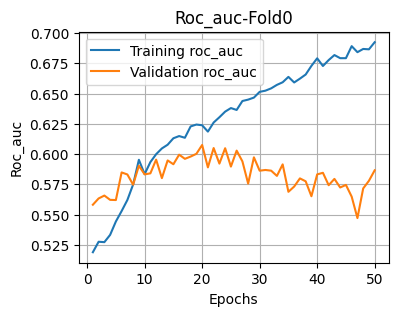

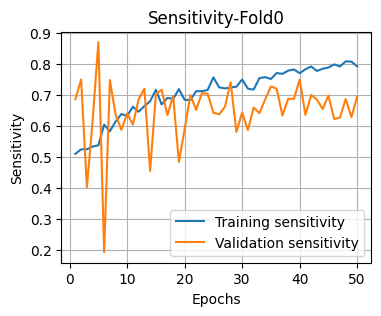

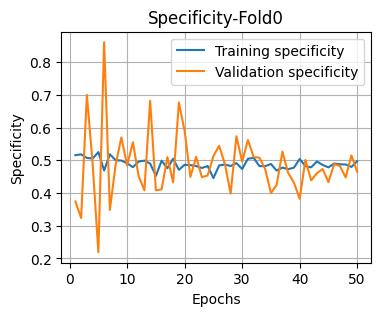

In [101]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [102]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.7 Dropout 0.5 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  795  525  36  46     0.560976     0.602273    0.08056  0.140888  0.074637   

    ROC_auc  
0  0.597579


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     795.0  525.0  36.0  46.0     0.560976     0.602273    0.08056  0.140888   
mean  795.0  525.0  36.0  46.0     0.561000     0.602300    0.08060  0.140900   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.074637  0.597579  
mean  0.074600  0.597600  
std        NaN       NaN

### Dropout 0.5; Reg_L2=1e-4

In [103]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 13s - 78ms/step - loss: 0.9695 - roc_auc: 0.5136 - sensitivity: 0.5140 - specificity: 0.5158 - val_loss: 0.7217 - val_roc_auc: 0.5183 - val_sensitivity: 0.3273 - val_specificity: 0.6939
Epoch 2/50
170/170 - 4s - 23ms/step - loss: 0.7785 - roc_auc: 0.5247 - sensitivity: 0.5075 - specificity: 0.5195 - val_loss: 0.7134 - val_roc_auc: 0.5340 - val_sensitivity: 0.4667 - val_specificity: 0.5924
Epoch 3/50
170/170 - 4s - 23ms/step - loss: 0.7363 - roc_auc: 0.5331 - sensitivity: 0.5278 - specificity: 0.5123 - val_loss: 0.7117 - val_roc_auc: 0.5436 - val_sensitivity: 0.3167 - val_specificity: 0.7152
Epoch 4/50
170/170 - 4s - 24ms/step - loss: 0.7264 - roc_auc: 0.5333 - sensitivity: 0.5221 - specificity: 0.5223 - val_loss: 0.7099 - val_roc_auc: 0.5622 - val_sensitivity: 0.6841 - val_specificity: 0.4258
Epoch 5/50
170/170 - 4s - 23ms/step - loss: 0.7188 - roc_auc: 0.5438 - sensitivity: 0.5358 - specificity: 0.5263 - val_loss: 0.7099 - val_roc_auc: 0.5653 - val_sensitivit

Metric       Value
0   True Negatives  707.000000
1  False Positives  613.000000
2  False Negatives   36.000000
3   True Positives   46.000000
4      Sensitivity    0.560976
5      Specificity    0.535606
6        Precision    0.069803
7         F1 Score    0.124157
8           PR AUC    0.067984
9          ROC AUC    0.574695

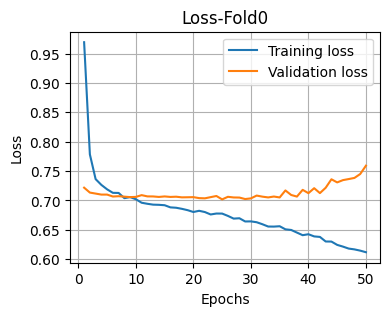

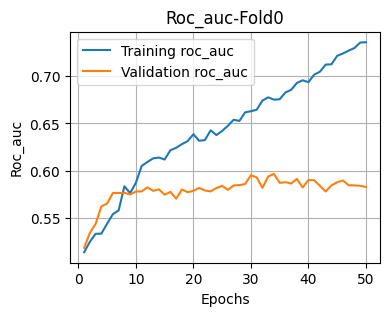

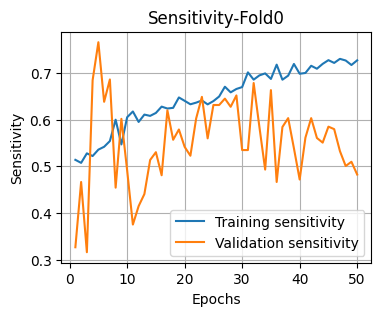

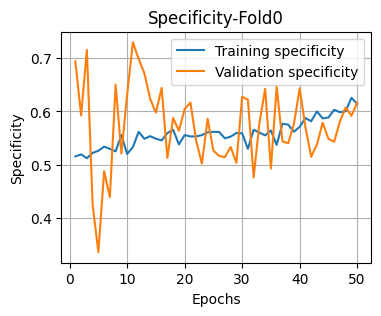

In [104]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [105]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.7 Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  707  613  36  46     0.560976     0.535606   0.069803  0.124157  0.067984   

    ROC_auc  
0  0.574695


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     707.0  613.0  36.0  46.0     0.560976     0.535606   0.069803  0.124157   
mean  707.0  613.0  36.0  46.0     0.561000     0.535600   0.069800  0.124200   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.067984  0.574695  
mean  0.068000  0.574700  
std        NaN       NaN

### Dropout 0.7; Reg_L2=1e-2

In [106]:
Dropout = 0.7
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 13s - 77ms/step - loss: 3.1350 - roc_auc: 0.4996 - sensitivity: 0.5110 - specificity: 0.4923 - val_loss: 2.4900 - val_roc_auc: 0.5231 - val_sensitivity: 0.8795 - val_specificity: 0.1348
Epoch 2/50
170/170 - 4s - 24ms/step - loss: 2.4115 - roc_auc: 0.5118 - sensitivity: 0.5208 - specificity: 0.5029 - val_loss: 2.0941 - val_roc_auc: 0.5331 - val_sensitivity: 0.9576 - val_specificity: 0.0568
Epoch 3/50
170/170 - 4s - 23ms/step - loss: 1.9685 - roc_auc: 0.5081 - sensitivity: 0.5306 - specificity: 0.4836 - val_loss: 1.7485 - val_roc_auc: 0.5374 - val_sensitivity: 0.7379 - val_specificity: 0.3159
Epoch 4/50
170/170 - 4s - 23ms/step - loss: 1.6302 - roc_auc: 0.5139 - sensitivity: 0.5208 - specificity: 0.5005 - val_loss: 1.4711 - val_roc_auc: 0.5319 - val_sensitivity: 0.9795 - val_specificity: 0.0167
Epoch 5/50
170/170 - 4s - 24ms/step - loss: 1.3732 - roc_auc: 0.5170 - sensitivity: 0.5359 - specificity: 0.4884 - val_loss: 1.2566 - val_roc_auc: 0.5349 - val_sensitivit

Metric       Value
0   True Negatives  873.000000
1  False Positives  447.000000
2  False Negatives   38.000000
3   True Positives   44.000000
4      Sensitivity    0.536585
5      Specificity    0.661364
6        Precision    0.089613
7         F1 Score    0.153578
8           PR AUC    0.074584
9          ROC AUC    0.600462

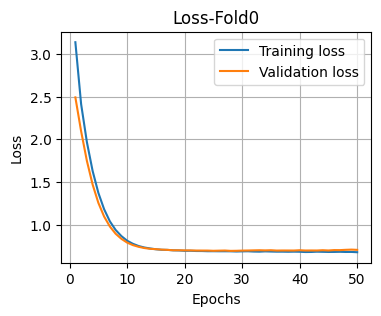

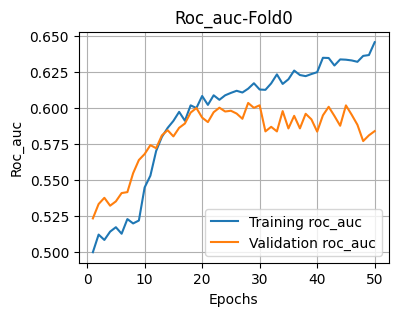

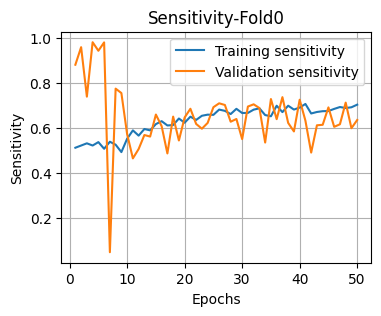

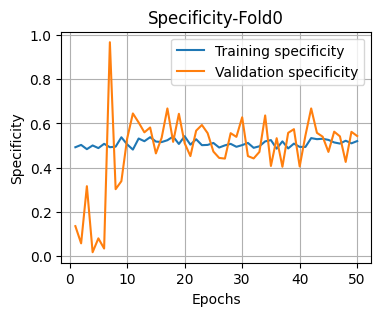

In [107]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [108]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.7 Dropout 0.7 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  873  447  38  44     0.536585     0.661364   0.089613  0.153578  0.074584   

    ROC_auc  
0  0.600462


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     873.0  447.0  38.0  44.0     0.536585     0.661364   0.089613  0.153578   
mean  873.0  447.0  38.0  44.0     0.536600     0.661400   0.089600  0.153600   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.074584  0.600462  
mean  0.074600  0.600500  
std        NaN       NaN

### Dropout 0.7; Reg_L2=1e-4

In [109]:
Dropout = 0.7
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 50
PATIENCE_ES  = 50



=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/50
170/170 - 13s - 79ms/step - loss: 1.1367 - roc_auc: 0.5122 - sensitivity: 0.5341 - specificity: 0.4853 - val_loss: 0.7202 - val_roc_auc: 0.5277 - val_sensitivity: 0.7318 - val_specificity: 0.3114
Epoch 2/50
170/170 - 4s - 23ms/step - loss: 0.8538 - roc_auc: 0.5065 - sensitivity: 0.5252 - specificity: 0.4825 - val_loss: 0.7148 - val_roc_auc: 0.5370 - val_sensitivity: 0.8856 - val_specificity: 0.1235
Epoch 3/50
170/170 - 4s - 24ms/step - loss: 0.7729 - roc_auc: 0.5044 - sensitivity: 0.5156 - specificity: 0.4916 - val_loss: 0.7133 - val_roc_auc: 0.5396 - val_sensitivity: 0.7841 - val_specificity: 0.2727
Epoch 4/50
170/170 - 4s - 24ms/step - loss: 0.7386 - roc_auc: 0.5193 - sensitivity: 0.5243 - specificity: 0.5001 - val_loss: 0.7143 - val_roc_auc: 0.5422 - val_sensitivity: 0.9773 - val_specificity: 0.0538
Epoch 5/50
170/170 - 4s - 23ms/step - loss: 0.7289 - roc_auc: 0.5178 - sensitivity: 0.5191 - specificity: 0.5032 - val_loss: 0.7141 - val_roc_auc: 0.5420 - val_sensitivit

Metric       Value
0   True Negatives  720.000000
1  False Positives  600.000000
2  False Negatives   32.000000
3   True Positives   50.000000
4      Sensitivity    0.609756
5      Specificity    0.545455
6        Precision    0.076923
7         F1 Score    0.136612
8           PR AUC    0.067735
9          ROC AUC    0.574880

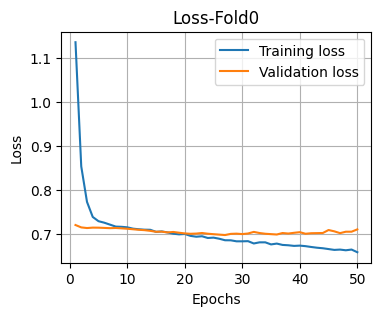

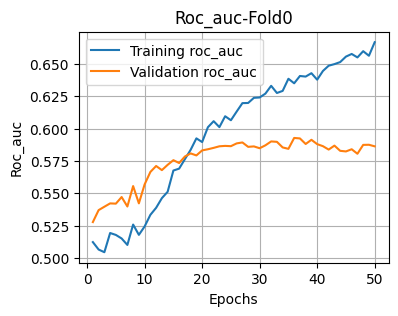

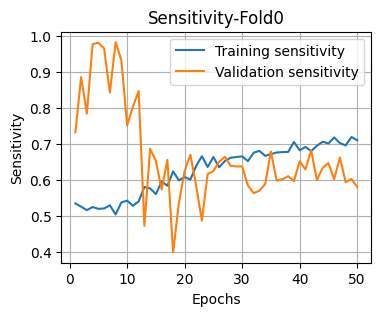

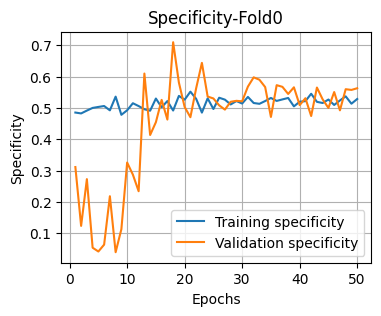

In [110]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [111]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.7 Dropout 0.7 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  720  600  32  50     0.609756     0.545455   0.076923  0.136612  0.067735   

   ROC_auc  
0  0.57488


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     720.0  600.0  32.0  50.0     0.609756     0.545455   0.076923  0.136612   
mean  720.0  600.0  32.0  50.0     0.609800     0.545500   0.076900  0.136600   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc  ROC_auc  
0     0.067735  0.57488  
mean  0.067700  0.57490  
std        NaN      NaN

### Dropout 0.9; Reg_L2=1e-2

In [112]:
Dropout = 0.9
Reg_L2 = 1e-2

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 150
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/150
170/170 - 13s - 77ms/step - loss: 4.0979 - roc_auc: 0.5020 - sensitivity: 0.4988 - specificity: 0.5066 - val_loss: 2.7102 - val_roc_auc: 0.4597 - val_sensitivity: 0.2712 - val_specificity: 0.6803
Epoch 2/150
170/170 - 4s - 24ms/step - loss: 3.2207 - roc_auc: 0.4999 - sensitivity: 0.4981 - specificity: 0.5023 - val_loss: 2.4707 - val_roc_auc: 0.4893 - val_sensitivity: 0.1667 - val_specificity: 0.8053
Epoch 3/150
170/170 - 4s - 23ms/step - loss: 2.6437 - roc_auc: 0.5036 - sensitivity: 0.4982 - specificity: 0.5023 - val_loss: 2.2557 - val_roc_auc: 0.4961 - val_sensitivity: 0.0477 - val_specificity: 0.9545
Epoch 4/150
170/170 - 4s - 23ms/step - loss: 2.2655 - roc_auc: 0.4976 - sensitivity: 0.4927 - specificity: 0.5053 - val_loss: 2.0369 - val_roc_auc: 0.4910 - val_sensitivity: 0.2167 - val_specificity: 0.7788
Epoch 5/150
170/170 - 4s - 25ms/step - loss: 1.9751 - roc_auc: 0.4960 - sensitivity: 0.4975 - specificity: 0.4990 - val_loss: 1.8287 - val_roc_auc: 0.4995 - val_sensi

Metric       Value
0   True Negatives  867.000000
1  False Positives  453.000000
2  False Negatives   42.000000
3   True Positives   40.000000
4      Sensitivity    0.487805
5      Specificity    0.656818
6        Precision    0.081136
7         F1 Score    0.139130
8           PR AUC    0.097349
9          ROC AUC    0.598919

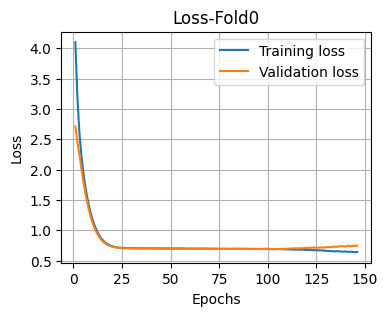

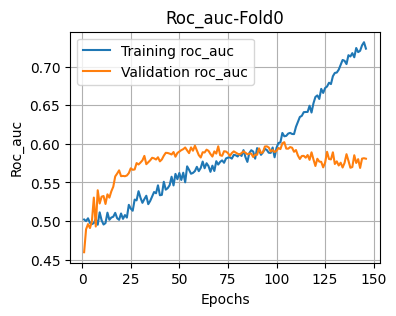

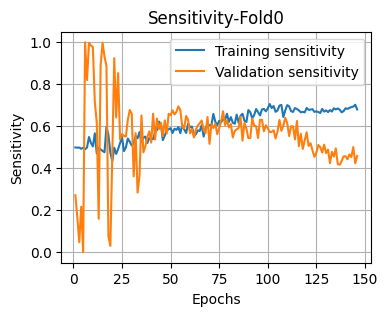

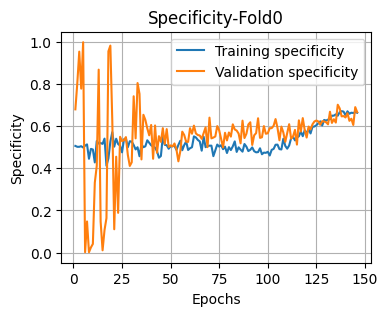

In [113]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [114]:
print('MASK_RATE',MASK_RATE , "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.7 Dropout 0.9 Reg_L2 0.01

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  867  453  42  40     0.487805     0.656818   0.081136   0.13913  0.097349   

    ROC_auc  
0  0.598919


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     867.0  453.0  42.0  40.0     0.487805     0.656818   0.081136   0.13913   
mean  867.0  453.0  42.0  40.0     0.487800     0.656800   0.081100   0.13910   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.097349  0.598919  
mean  0.097300  0.598900  
std        NaN       NaN

### Dropout 0.9; Reg_L2=1e-4

In [115]:
Dropout = 0.9
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 150
PATIENCE_ES  = 50


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/150
170/170 - 13s - 77ms/step - loss: 1.8744 - roc_auc: 0.4997 - sensitivity: 0.5025 - specificity: 0.4953 - val_loss: 0.7285 - val_roc_auc: 0.5333 - val_sensitivity: 0.7152 - val_specificity: 0.3053
Epoch 2/150
170/170 - 4s - 24ms/step - loss: 1.2281 - roc_auc: 0.4925 - sensitivity: 0.4896 - specificity: 0.4920 - val_loss: 0.7168 - val_roc_auc: 0.5207 - val_sensitivity: 0.8826 - val_specificity: 0.1280
Epoch 3/150
170/170 - 4s - 23ms/step - loss: 0.9243 - roc_auc: 0.4919 - sensitivity: 0.5038 - specificity: 0.4860 - val_loss: 0.7152 - val_roc_auc: 0.5143 - val_sensitivity: 0.7583 - val_specificity: 0.2576
Epoch 4/150
170/170 - 4s - 23ms/step - loss: 0.7859 - roc_auc: 0.5035 - sensitivity: 0.5010 - specificity: 0.5082 - val_loss: 0.7151 - val_roc_auc: 0.5410 - val_sensitivity: 0.0303 - val_specificity: 0.9773
Epoch 5/150
170/170 - 4s - 24ms/step - loss: 0.7447 - roc_auc: 0.5035 - sensitivity: 0.4862 - specificity: 0.5247 - val_loss: 0.7161 - val_roc_auc: 0.4844 - val_sensi

Metric       Value
0   True Negatives  836.000000
1  False Positives  484.000000
2  False Negatives   35.000000
3   True Positives   47.000000
4      Sensitivity    0.573171
5      Specificity    0.633333
6        Precision    0.088512
7         F1 Score    0.153344
8           PR AUC    0.072206
9          ROC AUC    0.586484

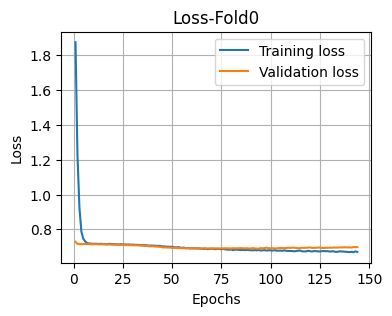

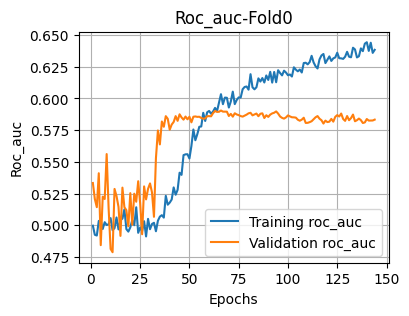

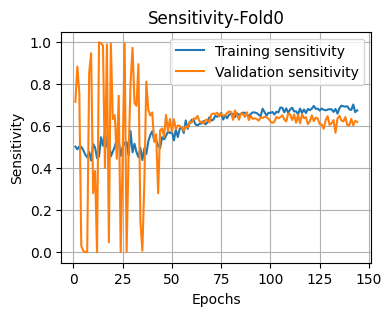

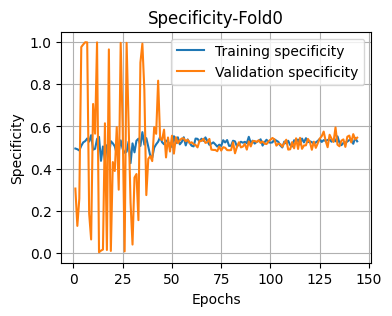

In [116]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    #  generate mask
    train_balanced_df.loc[:, 'Mask'] = train_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
    val_balanced_df.loc[:, 'Mask'] = val_balanced_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

    #   extract X mask
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])  # (N, T, F)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])    # (N, T, F)
    X_mask_os = np.stack(train_balanced_df["Mask"].to_numpy())
    X_val_mask_os = np.stack(val_balanced_df["Mask"].to_numpy())

    #   Mask Augment
    X_train_aug_os = X_train_nor_os * X_mask_os
    X_train_delta_aug_os = X_train_delta_nor_os * X_mask_os
    X_val_aug_os = X_val_nor_os * X_val_mask_os
    X_val_delta_aug_os = X_val_delta_nor_os * X_val_mask_os

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_train_nor_os.shape[1:], X_train_delta_nor_os.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_aug_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_aug_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    break

In [117]:
print("MASK_RATE", MASK_RATE, "Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

MASK_RATE 0.7 Dropout 0.9 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  836  484  35  47     0.573171     0.633333   0.088512  0.153344  0.072206   

    ROC_auc  
0  0.586484


Mean ± std across folds:


tn     fp    fn    tp  sensitivity  specificity  precision  f1_score  \
0     836.0  484.0  35.0  47.0     0.573171     0.633333   0.088512  0.153344   
mean  836.0  484.0  35.0  47.0     0.573200     0.633300   0.088500  0.153300   
std     NaN    NaN   NaN   NaN          NaN          NaN        NaN       NaN   

        PR_auc   ROC_auc  
0     0.072206  0.586484  
mean  0.072200  0.586500  
std        NaN       NaN